# Projet Lichess

_Traitements et données large échelle_

Zoé Marquis & Charlotte Kruzic

TODO : présenter les objectifs du projet, les différentes questions, les données utilisées


## Installation et importation des bibliothèques nécessaires

In [1]:
!pip install kagglehub

In [2]:
!pip install -q findspark

In [3]:
!pip install pyspark

In [4]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import kagglehub

import findspark
from pyspark.sql import SparkSession

In [5]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
!tar xf spark-3.5.3-bin-hadoop3.tgz

In [6]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

## Préparation des données et de l'environnement

Chargement des données, analyse exploratoire et prétraitement des données.

### Chargement du fichier de données

In [7]:
path = kagglehub.dataset_download("noobiedatascientist/lichess-september-2020-data")
print("Chemin vers le fichier du dataset : ", path)

100%|██████████| 324M/324M [00:03<00:00, 103MB/s]

Extracting files...


Chemin vers le fichier du dataset :  /root/.cache/kagglehub/datasets/noobiedatascientist/lichess-september-2020-data/versions/3


In [8]:
files = os.listdir(path)
print("Fichiers du dataset : ", files)

Fichiers du dataset :  ['Sept_20_analysis.RDS', 'Sept_20_analysis.csv', 'Column information.txt']


In [9]:
filename = f"{path}/Sept_20_analysis.csv"
print("Nom du fichier : ", filename)

Nom du fichier :  /root/.cache/kagglehub/datasets/noobiedatascientist/lichess-september-2020-data/versions/3/Sept_20_analysis.csv


In [10]:
# voir le contenu du .txt
filename_txt = f"{path}/Column information.txt"
with open(filename_txt, 'r') as f:
    print(f.read())

GAME: Game ID (not from lichess.org)

BlackElo: Elo rating of the player with the black pieces

BlackRatingDiff: Rating change (gain/loss) after game conclusion for the player with the black pieces

Date: Date the game was played

ECO: Game opening (ECO notation)

Event: Event where the game was played

Opening: Game opening

Result: Result of the game

	1-0 -- White victory
	0-1 -- Black victory
	1/2-1/2 -- Draw
	* -- Undecided
	
Site: URL of the game

Termination: Way the game terminated

	Time forfeit -- One of the players ran out of time
	Normal -- Game terminated with check mate
	Rules infraction -- Game terminated due to rule breaking
	Abandoned -- Game was abandoned
	
TimeControl: Timecontrol in seconds that was used for the game (Starting time: Increment) 

UTCTime: Time the game was played

WhiteElo: Elo rating of the player with the white pieces

WhiteRatingDiff: Rating change (gain/loss) after game conclusion for the player with the white pieces

Black_elo_category: ELO cate

### Lancement de Spark

In [11]:
# Importation des éléments Spark
from pyspark.sql.functions import col, when, isnull, floor, count, min as spark_min, max as spark_max, countDistinct, row_number, split, concat_ws, sum as spark_sum, rank
from pyspark.sql.window import Window
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from collections import defaultdict

In [12]:
findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [13]:
sc = spark.sparkContext
df_spark = spark.read.csv(filename, header=True, inferSchema=True)

In [14]:
df_spark.printSchema()

root
 |-- GAME: integer (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- BlackRatingDiff: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- ECO: string (nullable = true)
 |-- Event: string (nullable = true)
 |-- Opening: string (nullable = true)
 |-- Result: string (nullable = true)
 |-- Site: string (nullable = true)
 |-- Termination: string (nullable = true)
 |-- TimeControl: string (nullable = true)
 |-- UTCTime: timestamp (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- WhiteRatingDiff: integer (nullable = true)
 |-- Black_elo_category: string (nullable = true)
 |-- White_elo_category: string (nullable = true)
 |-- starting_time: integer (nullable = true)
 |-- increment: integer (nullable = true)
 |-- Game_type: string (nullable = true)
 |-- Total_moves: integer (nullable = true)
 |-- Black_blunders: integer (nullable = true)
 |-- White_blunders: integer (nullable = true)
 |-- Black_mistakes: integer (nullable = true)
 |-- White_mistak

In [15]:
# nombre lignes
df_spark.count()

3739909

In [16]:
df_spark.show(5)

+----+--------+---------------+----------+---+----------------+--------------------+------+--------------------+------------+-----------+-------------------+--------+---------------+------------------+------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+
|GAME|BlackElo|BlackRatingDiff|      Date|ECO|           Event|             Opening|Result|                Site| Termination|TimeControl|            UTCTime|WhiteElo|WhiteRatingDiff|Black_elo_category|White_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_

### Préparation générale des données

Maintenant que les données sont chargées, nous y ajoutons les catégories ELO basées sur les plages données dans l'énoncé du projet.

En plus des 5 catégories définies dans l'énoncé, nous ajoutons "other lower bound" et "other upper bound" pour les valeurs ELO hors des plages.

#### Calcule des catégories ELO

In [17]:
# Ajout des catégories ELO
# Catégorie ELO du joueur Noir
df_spark_plus = df_spark.withColumn("Black_ELO_category",
                              when((col("BlackElo") >= 1200) & (col("BlackElo") <= 1499), "occasional player")
                              .when((col("BlackElo") >= 1500) & (col("BlackElo") <= 1799), "good club player")
                              .when((col("BlackElo") >= 1800) & (col("BlackElo") <= 1999), "very good club player")
                              .when((col("BlackElo") >= 2000) & (col("BlackElo") <= 2399), "national and international level")
                              .when((col("BlackElo") >= 2400) & (col("BlackElo") <= 2800), "GMI, World Champions")
                              .when((col("BlackElo") < 1200), "other lower bound")
                              .otherwise("other upper bound")
                              )

# Catégorie ELO du joueur Blanc
df_spark_plus = df_spark_plus.withColumn("White_ELO_category",
                              when((col("WhiteElo") >= 1200) & (col("WhiteElo") <= 1499), "occasional player")
                              .when((col("WhiteElo") >= 1500) & (col("WhiteElo") <= 1799), "good club player")
                              .when((col("WhiteElo") >= 1800) & (col("WhiteElo") <= 1999), "very good club player")
                              .when((col("WhiteElo") >= 2000) & (col("WhiteElo") <= 2399), "national and international level")
                              .when((col("WhiteElo") >= 2400) & (col("WhiteElo") <= 2800), "GMI, World Champions")
                              .when((col("WhiteElo") < 1200), "other lower bound")
                              .otherwise("other upper bound")
                              )

# Catégorie ELO moyenne des 2 joueurs
df_spark_plus = df_spark_plus.withColumn("Avg_ELO_category", (col("BlackElo") + col("WhiteElo")) / 2)

df_spark_plus = df_spark_plus.withColumn("Avg_ELO_category",
                              when((col("Avg_ELO_category") >= 1200) & (col("Avg_ELO_category") <= 1499), "occasional player")
                              .when((col("Avg_ELO_category") >= 1500) & (col("Avg_ELO_category") <= 1799), "good club player")
                              .when((col("Avg_ELO_category") >= 1800) & (col("Avg_ELO_category") <= 1999), "very good club player")
                              .when((col("Avg_ELO_category") >= 2000) & (col("Avg_ELO_category") <= 2399), "national and international level")
                              .when((col("Avg_ELO_category") >= 2400) & (col("Avg_ELO_category") <= 2800), "GMI, World Champions")
                              .when((col("Avg_ELO_category") < 1200), "other lower bound")
                              .otherwise("other upper bound")
                              )

In [18]:
# vérifier combien de "other ..."
other_lower_bound_black = df_spark_plus.filter(col("Black_ELO_category") == "other lower bound").count()
other_lower_bound_white = df_spark_plus.filter(col("White_ELO_category") == "other lower bound").count()
other_upper_bound_black = df_spark_plus.filter(col("Black_ELO_category") == "other upper bound").count()
other_upper_bound_white = df_spark_plus.filter(col("White_ELO_category") == "other upper bound").count()
print(f"Nombre de parties avec other lower bound pour le joueur noir : {other_lower_bound_black}")
print(f"Nombre de parties avec other lower bound pour le joueur blanc : {other_lower_bound_white}")
print(f"Nombre de parties avec other upper bound pour le joueur noir : {other_upper_bound_black}")
print(f"Nombre de parties avec other upper bound pour le joueur blanc : {other_upper_bound_white}")

Nombre de parties avec other lower bound pour le joueur noir : 474566
Nombre de parties avec other lower bound pour le joueur blanc : 477997
Nombre de parties avec other upper bound pour le joueur noir : 1730
Nombre de parties avec other upper bound pour le joueur blanc : 1721


In [19]:
# répartition du nombre de parties pour avg
avg_other_lower_bound = df_spark_plus.filter(col("Avg_ELO_category") == "other lower bound").count()
avg_occasional_player = df_spark_plus.filter(col("Avg_ELO_category") == "occasional player").count()
avg_good_club_player = df_spark_plus.filter(col("Avg_ELO_category") == "good club player").count()
avg_very_good_club_player = df_spark_plus.filter(col("Avg_ELO_category") == "very good club player").count()
avg_national_international_level = df_spark_plus.filter(col("Avg_ELO_category") == "national and international level").count()
avg_GMI_World_Champions = df_spark_plus.filter(col("Avg_ELO_category") == "GMI, World Champions").count()
avg_other_upper_bound = df_spark_plus.filter(col("Avg_ELO_category") == "other upper bound").count()

# répartition du nombre de parties quand les 2 joueurs sont dans la même catégorie
same_player_other_lower_bound = df_spark_plus.filter((col("Black_ELO_category") == "other lower bound") & (col("White_ELO_category") == "other lower bound")).count()
same_player_occasional_player = df_spark_plus.filter((col("Black_ELO_category") == "occasional player") & (col("White_ELO_category") == "occasional player")).count()
same_player_good_club_player = df_spark_plus.filter((col("Black_ELO_category") == "good club player") & (col("White_ELO_category") == "good club player")).count()
same_player_very_good_club_player = df_spark_plus.filter((col("Black_ELO_category") == "very good club player") & (col("White_ELO_category") == "very good club player")).count()
same_player_national_international_level = df_spark_plus.filter((col("Black_ELO_category") == "national and international level") & (col("White_ELO_category") == "national and international level")).count()
same_player_GMI_World_Champions = df_spark_plus.filter((col("Black_ELO_category") == "GMI, World Champions") & (col("White_ELO_category") == "GMI, World Champions")).count()
same_player_other_upper_bound = df_spark_plus.filter((col("Black_ELO_category") == "other upper bound") & (col("White_ELO_category") == "other upper bound")).count()


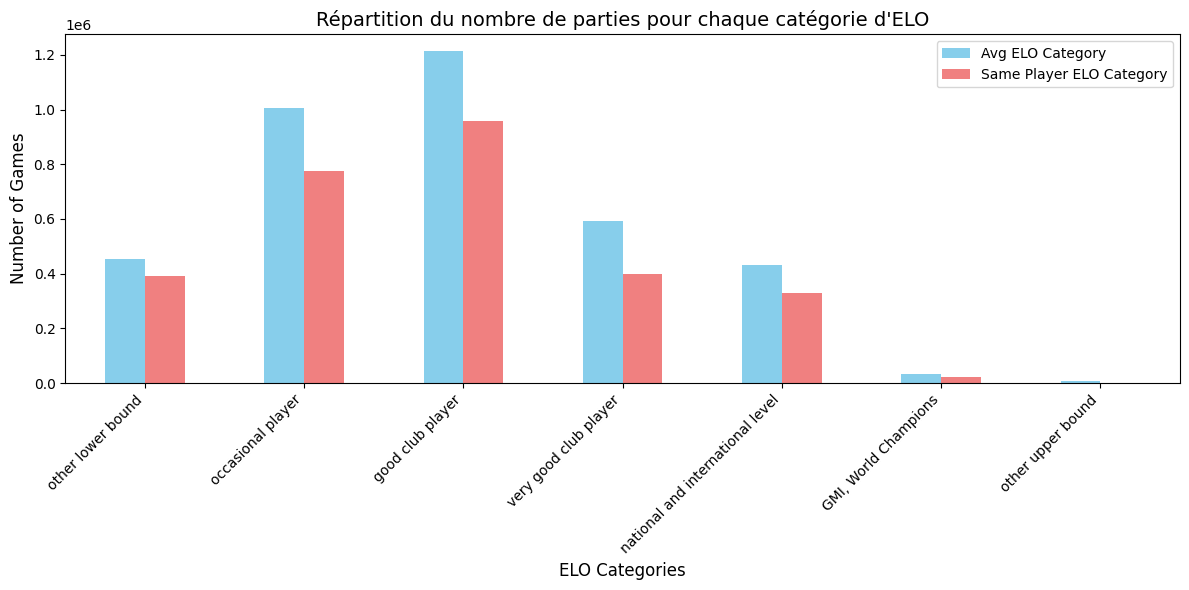

In [20]:
# Visualiser la répartition des catégories

categories = [
    "other lower bound", "occasional player", "good club player",
    "very good club player", "national and international level", "GMI, World Champions",
    "other upper bound"
]
avg_counts = [
    avg_other_lower_bound, avg_occasional_player, avg_good_club_player,
    avg_very_good_club_player, avg_national_international_level, avg_GMI_World_Champions,
    avg_other_upper_bound
]
same_player_counts = [
    same_player_other_lower_bound, same_player_occasional_player, same_player_good_club_player,
    same_player_very_good_club_player, same_player_national_international_level, same_player_GMI_World_Champions,
    same_player_other_upper_bound
]

df_counts = pd.DataFrame({
    'Category': categories,
    'Avg_ELO_category': avg_counts,
    'Same_Player_ELO_category': same_player_counts
})

plt.figure(figsize=(12, 6))
df_counts.set_index('Category')[['Avg_ELO_category', 'Same_Player_ELO_category']].plot(kind='bar', ax=plt.gca(), color=['skyblue', 'lightcoral'])
plt.xlabel('ELO Categories', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)
plt.title('Répartition du nombre de parties pour chaque catégorie d\'ELO', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(['Avg ELO Category', 'Same Player ELO Category'])
plt.tight_layout()
plt.show()

La répartition des données, bien que déséquilibrée entre les catégories, semble réaliste.

En effet, le nombre de parties avec des joueurs de niveaux intermédiaires est plus élevé, car ils représentent la plupart des joueurs actifs qui jouent régulièrement. Au contraire, le nombre de parties avec des joueurs ayant des niveaux extrêmes (faible ou élevé) est plus faible. Nous pouvons expliquer cela par le fait que les joueurs de bas niveau évoluent rapidement ou ne jouent pas beaucoup de parties, et les joueurs avec de hauts niveaux sont plus rares dû à la difficulté d'atteindre ces niveaux.

Ce déséquilibre naturel pourrait introduire un biais dans l'analyse, car certaines catégories sont sur/sous-représentées.

#### Récupérer le nombre de mouvements par joueur

In [21]:
# Compter le nombre de moves pour chaque joueur (c'est White qui commence)
df_spark_plus = df_spark_plus.withColumn("white_moves",
                                         when(col("Total_moves") % 2 == 0, col("Total_moves") / 2)
                                         .otherwise(floor(col("Total_moves") / 2) + 1)
                                         )
df_spark_plus = df_spark_plus.withColumn("black_moves",
                                         when(col("Total_moves") % 2 == 0, col("Total_moves") / 2)
                                         .otherwise(floor(col("Total_moves") / 2))
                                         )

In [22]:
df_spark_plus.select("Total_moves", "white_moves", "black_moves").show(5)

+-----------+-----------+-----------+
|Total_moves|white_moves|black_moves|
+-----------+-----------+-----------+
|         66|       33.0|       33.0|
|         64|       32.0|       32.0|
|         70|       35.0|       35.0|
|         86|       43.0|       43.0|
|         71|       36.0|       35.0|
+-----------+-----------+-----------+
only showing top 5 rows



#### Vérification des données

In [23]:
# TODO : Décider si on garde cette partie
# je l'appelerais pas comme ça mai sje pense on garde

##### **Valeurs NULL**

In [24]:
# Calcule valeurs null par colonnes
null_counts = df_spark.select(
    *[
        count(when(col(c).isNull(), c)).alias(c)
        for c in df_spark.columns
    ]
)

null_counts.show()

+----+--------+---------------+----+---+-----+-------+------+----+-----------+-----------+-------+--------+---------------+------------------+------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+
|GAME|BlackElo|BlackRatingDiff|Date|ECO|Event|Opening|Result|Site|Termination|TimeControl|UTCTime|WhiteElo|WhiteRatingDiff|Black_elo_category|White_elo_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_inferior_moves|Black_ts_moves|White_ts_moves|Black_ts_blunders|White_ts_blunders|Black_ts_mistakes|White_ts_mistake|Bl

##### **Colonnes Opening et ECO**

In [25]:
# TODO : J'ai checké sur Google, et c'est connu que ECO c'est par comme Opening lol (donc je pense on vire)

Les colonnes "Opening" et "ECO" correspondent aux ouvertures et aux codes d'ouvertures, nous regardons si elles sont en liens.

In [26]:
# Nombre valeurs opening
print(f"Nombre de valeurs opening : {df_spark.select('Opening').distinct().count()}")
print(f"Nombre de valeurs ECO : {df_spark.select('ECO').distinct().count()}")

Nombre de valeurs opening : 2790
Nombre de valeurs ECO : 492


In [27]:
#  Checker si une valeur de Opening = une valeur de ECO
alignment_check_1 = df_spark.groupBy("ECO").agg(countDistinct("Opening").alias("Unique_Openings"))
misaligned_rows_1 = alignment_check_1.filter(col("Unique_Openings") > 1)

In [28]:
# Afficher les résultats
if misaligned_rows_1.count() > 0:
    print("Il existe plusieurs Openings pour un code ECO.")
    misaligned_rows_1.show(5)
    print("Nombre de lignes : ", misaligned_rows_1.count())
else:
    print("Il existe un seul Opening pour un code ECO.")

Il existe plusieurs Openings pour un code ECO.
+---+---------------+
|ECO|Unique_Openings|
+---+---------------+
|B05|              4|
|B79|              2|
|A47|              3|
|E83|              3|
|B34|              3|
+---+---------------+
only showing top 5 rows

Nombre de lignes :  353


In [29]:
#  Checker si une valeur de ECO = une valeur de Opening
alignment_check_2 = df_spark.groupBy("Opening").agg(countDistinct("ECO").alias("Unique_ECOs"))
misaligned_rows_2 = alignment_check_2.filter(col("Unique_ECOs") > 1)

In [30]:
# Afficher les résultats
if misaligned_rows_2.count() > 0:
    print("Il existe plusieurs ECO pour un code Opening.")
    misaligned_rows_2.show(5)
    print("Nombre de lignes : ", misaligned_rows_2.count())
else:
    print("Il existe un seul ECO pour un code Opening.")

Il existe plusieurs ECO pour un code Opening.
+--------------------+-----------+
|             Opening|Unique_ECOs|
+--------------------+-----------+
|  St. George Defense|          2|
|Nimzo-Indian Defe...|          5|
|        Torre Attack|          2|
|   Caro-Kann Defense|          4|
|Sicilian Defense:...|          2|
+--------------------+-----------+
only showing top 5 rows

Nombre de lignes :  95


Nous remarquons qu'un Opening peut avoir plusieurs ECO, et qu'un ECO peut également avoir plusieurs Opening.  
Nous allons regarder si c'est normal.

In [31]:
# Filtrer pour les ouvertures ayant plusieurs ECO
misaligned_rows_2 = alignment_check_2.filter(col("Unique_ECOs") > 1)
opening_eco_counts = df_spark.groupBy("Opening", "ECO").agg(count("*").alias("count"))
multiple_opening_eco_counts = misaligned_rows_2.join(opening_eco_counts, on="Opening", how="inner")
multiple_opening_eco_counts.orderBy("Opening", "count", ascending=False).show(truncate=False)


+------------------------------------------------------------------------+-----------+---+-----+
|Opening                                                                 |Unique_ECOs|ECO|count|
+------------------------------------------------------------------------+-----------+---+-----+
|Vienna Game: Vienna Gambit                                              |2          |C28|3648 |
|Vienna Game: Vienna Gambit                                              |2          |C25|1193 |
|Torre Attack                                                            |2          |A46|1704 |
|Torre Attack                                                            |2          |A48|1587 |
|St. George Defense                                                      |2          |B00|4265 |
|St. George Defense                                                      |2          |C00|690  |
|Slav Defense: Exchange Variation                                        |2          |D10|5637 |
|Slav Defense: Exchange Variat

Cela ne semble pas être des erreurs, il n'y a pas de ECO ou Opening largement dominant, nous allons donc garder ces éléments comme cela et les considérer comme 2 colonnes distinctes, n'ayant pas de lien particulier.

##### **Colonnes starting_time, increment, et TimeControl**

Nous allons maintenant vérifier si les colonnes "starting_time", "increment", et "TimeControl" sont bien en accord avec la documentation.

In [32]:
# Même nombre null pour starting_time et increment, on vérifie que c'est aligné
df_spark.filter(col("starting_time").isNull() & col("increment").isNull()).count()

10344

In [33]:
# Afficher les type de game quand ces 2 colonnes sont NULL
df_spark.filter(col("starting_time").isNull() & col("increment").isNull()).select("Game_type").distinct().show()

+--------------+
|     Game_type|
+--------------+
|Correspondence|
+--------------+



In [34]:
# Afficher les parties avec type de jeu Correspondence et starting_time ou increment non null
df_spark.filter((col("Game_type") == "Correspondence") & (col("starting_time").isNotNull() | col("increment").isNotNull())).count()

0

Cela correspond à ce qui est attendu.

Maintenant, nous vérifions que TimeControl correspond bien à `starting_time+increment`.

In [35]:
# Extraire starting_time et increment à partir de TimeControl
df_spark_check = df_spark.withColumn(
    "starting_time_extracted",
    when(col("TimeControl") != "-", split(col("TimeControl"), "\+")[0].cast("int"))
    .otherwise(None))

df_spark_check = df_spark_check.withColumn(
    "increment_extracted",
    when(col("TimeControl") != "-", split(col("TimeControl"), "\+")[1].cast("int"))
    .otherwise(None))

# Recréer TimeControl avec les colonnes extraites
df_spark_check = df_spark_check.withColumn(
    "TimeControl_reconstructed",
    when(col("starting_time_extracted").isNull() & col("increment_extracted").isNull(), "-")
    .otherwise(concat_ws("+", col("starting_time_extracted"), col("increment_extracted")))
)

# Comparer TimeControl avec la recréation
df_spark_check = df_spark_check.withColumn(
    "is_matching",
    col("TimeControl") == col("TimeControl_reconstructed")
)

# Checker les résultats
df_spark_check.select("TimeControl", "starting_time", "increment", "starting_time_extracted", "increment_extracted", "TimeControl_reconstructed", "is_matching").show(5)
mismatch_count = df_spark_check.filter(col("is_matching") == False).count()
print(f"Nombre de différences : {mismatch_count}")

+-----------+-------------+---------+-----------------------+-------------------+-------------------------+-----------+
|TimeControl|starting_time|increment|starting_time_extracted|increment_extracted|TimeControl_reconstructed|is_matching|
+-----------+-------------+---------+-----------------------+-------------------+-------------------------+-----------+
|      300+0|          300|        0|                    300|                  0|                    300+0|       true|
|      300+0|          300|        0|                    300|                  0|                    300+0|       true|
|      300+2|          300|        2|                    300|                  2|                    300+2|       true|
|      180+2|          180|        2|                    180|                  2|                    180+2|       true|
|      600+0|          600|        0|                    600|                  0|                    600+0|       true|
+-----------+-------------+---------+---

##### **Colonnes BlackRatingDiff et WhiteRatingDiff**

In [36]:
df_spark.filter(col("BlackRatingDiff").isNull() & col("WhiteRatingDiff").isNull()).count()

12968

In [37]:
# pourcentage null
prc_missed = round(df_spark.filter(col("BlackRatingDiff").isNull() | col("WhiteRatingDiff").isNull()).count()/df_spark.count()*100,2)
print(f"Pourcentage de NULL : {prc_missed}%")

Pourcentage de NULL : 0.35%


## Réponses aux questions

### Question 1

In [38]:
# TODO rregarder au global inferior moves aussi ?
# Charlotte : "si c'est un commentaire pour moi, j'ai pas compris ce que ça veut dire mdrrr"
# pov : j'écris comme le théatre

*Q1: What is the rate of blunders, errors and inaccuracies per move, per level category and on Blitz type games (Blitz type is by far the most played on these online sites). A game has two players, whose ELOs are most likely different. You will be able to classify a game into a category, either by considering the average ELO of both players, or by considering only the games where both players are in the same category.*

**Hypothèse :** Les joueurs appartenant à des catégories plus expérimentées devraient présenter un taux d'erreurs plus faible.

In [39]:
# Filtre les parties avec le type de jeu Blitz
df_blitz = df_spark_plus.filter(col("Game_type") == "Blitz")
df_blitz.count()

1812120

#### Calcule des taux par partie

In [40]:
# Calcule taux de blunders
df_blitz = df_blitz.withColumn("Black_blunders_rate", col("Black_blunders") / col("black_moves")) \
                   .withColumn("White_blunders_rate", col("White_blunders") / col("white_moves"))

In [41]:
# Calcule taux d'errors
df_blitz = df_blitz.withColumn("Black_errors_rate", col("Black_mistakes") / col("black_moves")) \
                   .withColumn("White_errors_rate", col("White_mistakes") / col("white_moves"))

In [42]:
# Calcule taux d'inaccuracies
df_blitz = df_blitz.withColumn("Black_inaccuracies_rate", col("Black_inaccuracies") / col("black_moves")) \
                   .withColumn("White_inaccuracies_rate", col("White_inaccuracies") / col("white_moves"))

#### Calcule des taux moyens par catégorie ELO (on considère le score ELO moyen des 2 joueurs)

In [43]:
df_avg_elo_summary = df_blitz.groupBy("Avg_ELO_category").agg(
    {"Black_blunders_rate": "avg", "White_blunders_rate": "avg",
     "Black_errors_rate": "avg", "White_errors_rate": "avg",
     "Black_inaccuracies_rate": "avg", "White_inaccuracies_rate": "avg"}
).withColumnRenamed("avg(Black_blunders_rate)", "Avg_Black_blunders_rate") \
 .withColumnRenamed("avg(White_blunders_rate)", "Avg_White_blunders_rate") \
 .withColumnRenamed("avg(Black_errors_rate)", "Avg_Black_errors_rate") \
 .withColumnRenamed("avg(White_errors_rate)", "Avg_White_errors_rate") \
 .withColumnRenamed("avg(Black_inaccuracies_rate)", "Avg_Black_inaccuracies_rate") \
 .withColumnRenamed("avg(White_inaccuracies_rate)", "Avg_White_inaccuracies_rate")

In [44]:
df_avg_elo_summary.show(5)

+--------------------+---------------------------+-----------------------+---------------------+---------------------+-----------------------+---------------------------+
|    Avg_ELO_category|Avg_White_inaccuracies_rate|Avg_White_blunders_rate|Avg_Black_errors_rate|Avg_White_errors_rate|Avg_Black_blunders_rate|Avg_Black_inaccuracies_rate|
+--------------------+---------------------------+-----------------------+---------------------+---------------------+-----------------------+---------------------------+
|   other upper bound|        0.08923646820987065|   0.053883314861216475|  0.09786062988127485|  0.09316825168156774|    0.05713253835834972|        0.09422886449242146|
|   other lower bound|        0.09123664425761414|    0.09505881705406403|  0.11316469323850303|  0.10800044716165165|    0.09865934120262021|        0.09602531148536161|
|GMI, World Champions|        0.07247529070529041|    0.03077546627182289|  0.06824732477795835|  0.06620118207859484|    0.03325752004748459|   

In [45]:
df_avg_elo_summary_pandas = df_avg_elo_summary.toPandas()

In [46]:
df_avg_elo_summary_pandas.isna().sum()

,0
Avg_ELO_category,0
Avg_White_inaccuracies_rate,0
Avg_White_blunders_rate,0
Avg_Black_errors_rate,0
Avg_White_errors_rate,0
Avg_Black_blunders_rate,0
Avg_Black_inaccuracies_rate,0


In [47]:
# Ordonner les catégories de joueurs
category_order = ["other lower bound", "occasional player", "good club player", "very good club player",
                  "national and international level", "GMI, World Champions", "other upper bound"]
df_avg_elo_summary_pandas['Avg_ELO_category'] = pd.Categorical(df_avg_elo_summary_pandas['Avg_ELO_category'],  categories=category_order,  ordered=True)
df_avg_elo_summary_pandas = df_avg_elo_summary_pandas.sort_values('Avg_ELO_category')


categories = df_avg_elo_summary_pandas['Avg_ELO_category']
error_types = ['Blunders', 'Errors', 'Inaccuracies']

# Données par type d'erreur et catégorie
blunders = df_avg_elo_summary_pandas[['Avg_Black_blunders_rate', 'Avg_White_blunders_rate']].mean(axis=1)*100
mistakes = df_avg_elo_summary_pandas[['Avg_Black_errors_rate', 'Avg_White_errors_rate']].mean(axis=1)*100
inaccuracies = df_avg_elo_summary_pandas[['Avg_Black_inaccuracies_rate', 'Avg_White_inaccuracies_rate']].mean(axis=1)*100

# Matrice (erreurs x catégorie)
data = np.array([blunders, mistakes, inaccuracies]).T

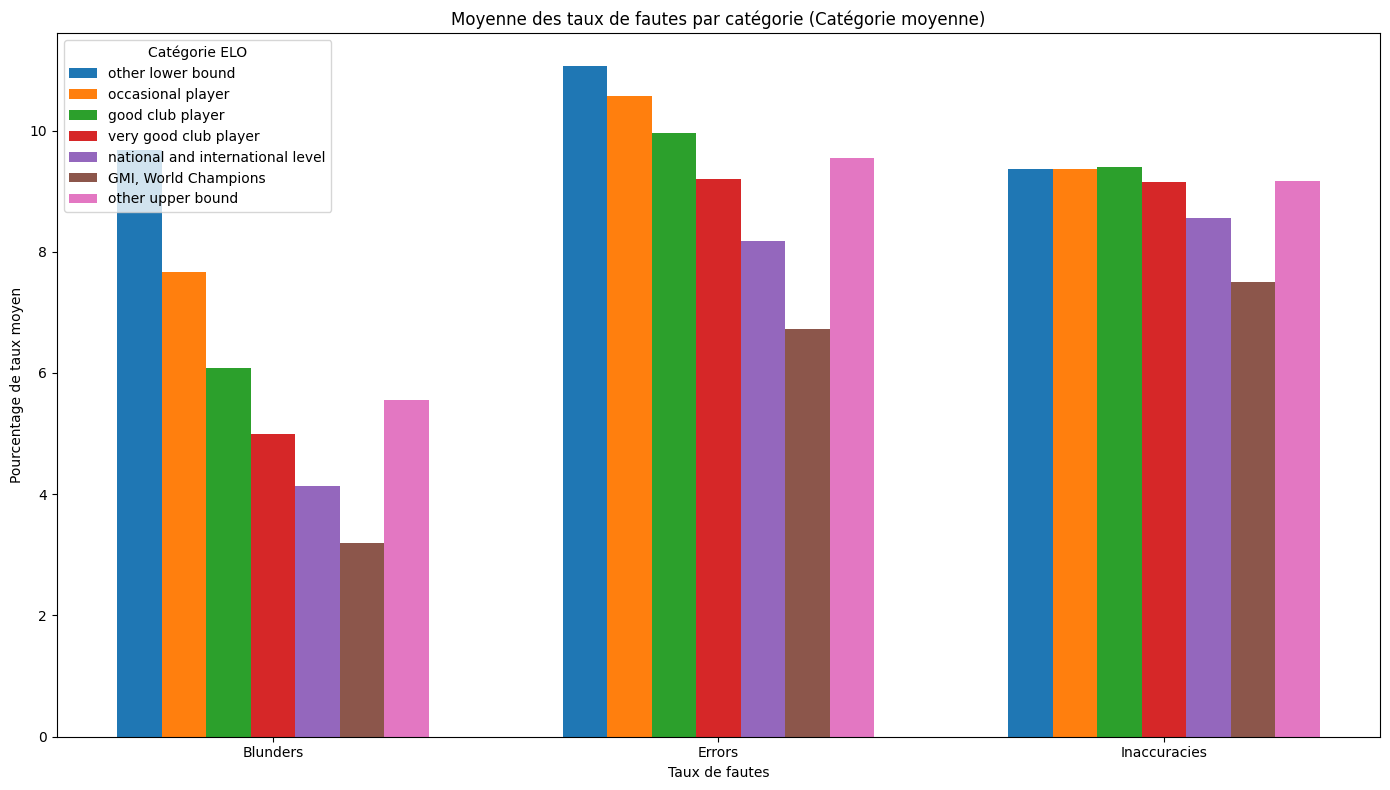

In [48]:
# Graphique
plt.figure(figsize=(14, 8))
x = np.arange(len(error_types))
bar_width = 0.1

for i, category in enumerate(categories):
    plt.bar(x + i * bar_width, data[i], width=bar_width, label=str(category))

plt.xlabel('Taux de fautes')
plt.ylabel('Pourcentage de taux moyen')
plt.title('Moyenne des taux de fautes par catégorie (Catégorie moyenne)')
plt.xticks(x + bar_width * (len(categories) - 1) / 2, error_types)
plt.legend(title="Catégorie ELO")
plt.tight_layout()
plt.show()

##### **Analyse des taux de blunders, errors et inaccuracies selon les catégories d'ELO**

Lorsque l'on analyse les taux de blunders, errors et inaccuracies en fonction des différentes catégories ELO, plusieurs tendances intéressantes émergent.  
En excluant la catégorie "Other Upper Bound", on observe une diminution progressive des taux de **bourdes** (blunders) à mesure que les catégories augmentent, avec une chute de moins en moins marquée. Cela suggère qu'il y a une amélioration du niveau des joueurs en fonction de leur catégorie ELO, bien qu'elle soit de moins en moins évidente pour les catégories les plus expérimentées.

Concernant les taux d'**erreurs** (errors), la diminution est relativement constante à travers les catégories, mais on remarque une chute plus importante lorsque l'on atteint les deux meilleures catégories ("National and International Level" et "GMI, World Champions"). Cela indique une amélioration notable dans la gestion des erreurs pour les joueurs de niveau supérieur.

Quant aux taux d'**imprécisions** (inaccuracies), la tendance reste assez stable pour les premières catégories, avec une diminution qui s'accélère à mesure que l'on approche des deux catégories les plus élevées. Cette tendance suggère également une amélioration du jeu des joueurs plus expérimentés.

En résumé, **les taux diminuent sensiblement à mesure que l'on progresse dans les catégories ELO**, avec une amélioration plus marquée pour les catégories "National and International Level" et "GMI, World Champions", ce qui reflète probablement un meilleur contrôle stratégique et une plus grande expérience des joueurs.

##### **Analyse de la catégorie "Other Upper Bound"**

Lorsque l'on considère la catégorie "Other Upper Bound", une tendance différente se dessine.  
Les taux de blunders, errors et inaccuracies semblent augmenter pour atteindre une **valeur entre celle des catégories "Good Club Player" et "Very Good Club Player"**.

Cette anomalie pourrait suggérer plusieurs pistes d'interprétation.  
Tout d'abord, il est possible que cette catégorie contienne des **données** qui ne sont **pas représentatives** du reste des catégories en raison d'un échantillon trop faible ou non nettoyé correctement.

Une autre hypothèse pourrait être que la **performance** des joueurs dans cette catégorie est **influencée** par la moyenne des ELO des deux joueurs, et non seulement par l'ELO individuel.  
Par exemple, un joueur avec un ELO élevé qui affronte un adversaire de niveau inférieur pourrait être amené à prendre plus de risques ou adopter des stratégies différentes, ce qui expliquerait certains résultats.  
De plus, il est possible qu'une partie classée dans la catégorie "Other upper bound" n'inclue qu'un seul joueur avec un ELO très élevé, ce qui fausse la moyenne des deux scores ELO et pourrait influencer l'analyse des performances.

#### Calcule des taux moyens par catégorie ELO (ici on considère seulement les parties où les joueurs sont dans la même catégorie)


In [49]:
df_same_category = df_blitz.filter(col("Black_ELO_category") == col("White_ELO_category"))

In [50]:
tot_blitz = df_blitz.count()
tot_same_cat = df_same_category.count()
print(f"Nombre de parties total : {tot_blitz}")
print(f"Nombre de parties avec 2 joueurs de la même catégorie : {tot_blitz}")
print(f"Pourcentage même catégorie : {tot_same_cat / tot_blitz * 100} %")

Nombre de parties total : 1812120
Nombre de parties avec 2 joueurs de la même catégorie : 1812120
Pourcentage même catégorie : 77.09219036266914 %


In [51]:
df_same_category_summary = df_same_category.groupBy("Black_ELO_category").agg(
    {"Black_blunders_rate": "avg", "White_blunders_rate": "avg",
     "Black_errors_rate": "avg", "White_errors_rate": "avg",
     "Black_inaccuracies_rate": "avg", "White_inaccuracies_rate": "avg"}
).withColumnRenamed("avg(Black_blunders_rate)", "Avg_Black_blunders_rate") \
 .withColumnRenamed("avg(White_blunders_rate)", "Avg_White_blunders_rate") \
 .withColumnRenamed("avg(Black_errors_rate)", "Avg_Black_errors_rate") \
 .withColumnRenamed("avg(White_errors_rate)", "Avg_White_errors_rate") \
 .withColumnRenamed("avg(Black_inaccuracies_rate)", "Avg_Black_inaccuracies_rate") \
 .withColumnRenamed("avg(White_inaccuracies_rate)", "Avg_White_inaccuracies_rate")

In [52]:
df_same_category_summary_pandas = df_same_category_summary.toPandas()

In [53]:
# Ordonner les catégories de joueurs
category_order = ["other lower bound", "occasional player", "good club player", "very good club player",
                  "national and international level", "GMI, World Champions", "other upper bound"]
df_same_category_summary_pandas['Black_ELO_category'] = pd.Categorical(df_same_category_summary_pandas['Black_ELO_category'],  categories=category_order,  ordered=True)
df_same_category_summary_pandas = df_same_category_summary_pandas.sort_values('Black_ELO_category')


categories = df_same_category_summary_pandas['Black_ELO_category']
error_types = ['Blunders', 'Errors', 'Inaccuracies']

# Données par type d'erreur et catégorie (moyenne) # TODO : Voir si on fait autrement
blunders = df_same_category_summary_pandas[['Avg_Black_blunders_rate', 'Avg_White_blunders_rate']].mean(axis=1)*100
mistakes = df_same_category_summary_pandas[['Avg_Black_errors_rate', 'Avg_White_errors_rate']].mean(axis=1)*100
inaccuracies = df_same_category_summary_pandas[['Avg_Black_inaccuracies_rate', 'Avg_White_inaccuracies_rate']].mean(axis=1)*100

# Matrice (erreurs x catégorie)
data = np.array([blunders, mistakes, inaccuracies]).T

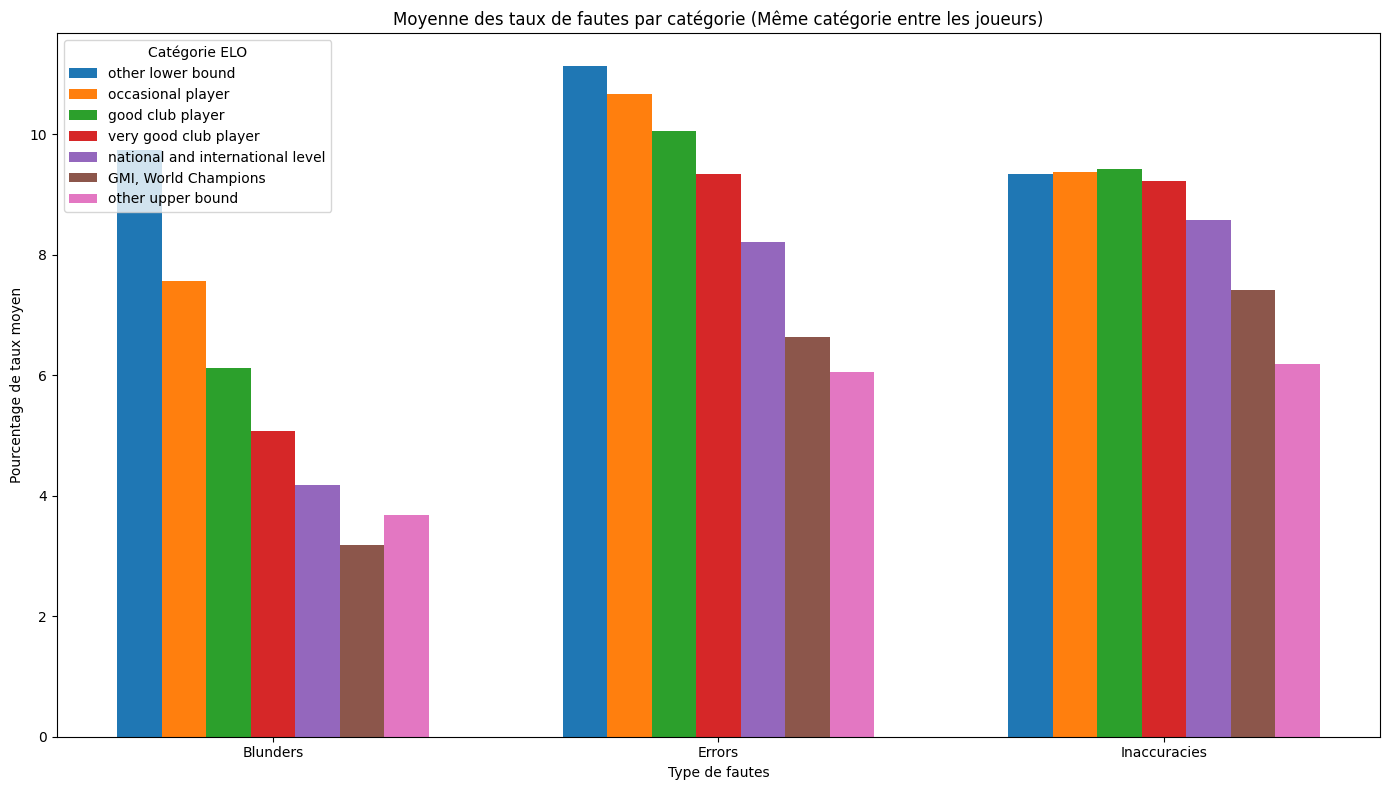

In [54]:
# Graphique
plt.figure(figsize=(14, 8))
x = np.arange(len(error_types))
bar_width = 0.1
for i, category in enumerate(categories):
    plt.bar(x + i * bar_width, data[i], width=bar_width, label=str(category))

plt.xlabel('Type de fautes')
plt.ylabel('Pourcentage de taux moyen')
plt.title('Moyenne des taux de fautes par catégorie (Même catégorie entre les joueurs)')
plt.xticks(x + bar_width * (len(categories) - 1) / 2, error_types)
plt.legend(title="Catégorie ELO")
plt.tight_layout()
plt.show()

Pour ces parties, où les deux joueurs appartiennent à la même catégorie, **les observations sont similaires** à celles faites pour la moyenne des ELO des joueurs.

Cependant, pour la catégorie **"Other upper bound"**, on ne constate **pas de réaugmentation** des erreurs et inexactitudes, ce qui confirme que la moyenne des ELO des deux joueurs influençait les résultats dans cette catégorie.

Inversement, une légère réaugmentation des blunders est observée entre les catégories "National and International level" et "GMI, World Champions".

#### Résultats globaux

Nous observons des **résultats similaires** entre les parties où les catégories sont basées sur la moyenne des ELO des deux joueurs et celles où les deux joueurs appartiennent à la même catégorie ELO. Nous voyons, en effet, que tous **les taux de fautes ont tendance à diminuer** à mesure que la catégorie ELO augmente.

Ce résultat est en accord avec l'hypothèse initiale : Les joueurs appartenant à des catégories plus expérimentées devraient présenter un taux d'erreurs plus faible.

### Question 2

#### Q2: Win probability depending on opening:


**Hypothèse :** Les openings permettant aux blancs de gagner devrait être différents de ceux permettant aux noirs de gagner.

#####  **Q2a: With which opening does White have the best chance to win, by level category (*) and by type of game (Blitz, Fast, Classic).**


**Premières observations :**   
Nous avons constaté que certaines configurations n’étaient jouées que très rarement et aboutissaient systématiquement à une victoire des Blancs.  
Cela introduit un biais et ne permet pas d’identifier correctement quel opening offre réellement le plus de chances de gagner.  
En effet, plus de 3 800 configurations présentaient une White_win_probability égale à 1.

Nous avons donc décidé de conserver uniquement les configurations avec un nombre élevé de parties jouées afin d’obtenir des résultats plus pertinents.

Nous allons analyser les configurations possibles, c'est à dire les combinaisons de `Opening`, `White_ELO_category`, et `Game_type`.

In [55]:
# Calculer le nombre de parties pour chaque configuration
config_game_counts = df_spark_plus.groupBy("Opening", "White_ELO_category", "Game_type").agg(count("*").alias("Total_games_count"))
config_game_counts.orderBy("Total_games_count", ascending=False).show(5)

+--------------------+------------------+---------+-----------------+
|             Opening|White_ELO_category|Game_type|Total_games_count|
+--------------------+------------------+---------+-----------------+
|Queen's Pawn Game...| occasional player|    Blitz|            11963|
|Queen's Pawn Game...|  good club player|    Blitz|            11456|
|    Philidor Defense| occasional player|    Blitz|            10246|
|    Philidor Defense|  good club player|    Blitz|             9800|
|    Sicilian Defense|  good club player|    Blitz|             9702|
+--------------------+------------------+---------+-----------------+
only showing top 5 rows



In [56]:
# Nombre total de configurations uniques
print(f"Nombre total de configurations possibles : {config_game_counts.count()}")
print(f"Nombre de configurations possibles pour les différents types de jeux :")
config_game_counts.groupBy("Game_type").count().orderBy("count", ascending=False).show()

Nombre total de configurations possibles : 44438
Nombre de configurations possibles pour les différents types de jeux :
+--------------+-----+
|     Game_type|count|
+--------------+-----+
|         Blitz|12957|
|        Bullet|11401|
|         Rapid|10377|
|     Classical| 6892|
|Correspondence| 2811|
+--------------+-----+



In [57]:
# Nombre d'Opening par configurations
df_spark_plus.groupBy("White_ELO_category", "Game_type").count().orderBy("count", ascending=False).show(34)

+--------------------+--------------+------+
|  White_ELO_category|     Game_type| count|
+--------------------+--------------+------+
|    good club player|         Blitz|549747|
|   occasional player|         Blitz|450990|
|    good club player|         Rapid|350294|
|very good club pl...|         Blitz|287985|
|   occasional player|         Rapid|262582|
|national and inte...|         Blitz|254839|
|    good club player|        Bullet|245115|
|   other lower bound|         Blitz|243316|
|   occasional player|        Bullet|227062|
|very good club pl...|         Rapid|162121|
|   other lower bound|        Bullet|132848|
|very good club pl...|        Bullet|106572|
|   other lower bound|         Rapid| 95046|
|national and inte...|         Rapid| 94355|
|national and inte...|        Bullet| 81839|
|    good club player|     Classical| 63684|
|   occasional player|     Classical| 31710|
|very good club pl...|     Classical| 29430|
|GMI, World Champions|         Blitz| 24942|
|national 

Nous pouvons voir que le nombre de parties jouées par type de jeux n'est pas répartie de façon uniforme, et que certaines configurations sont très sous représentées.

In [58]:
# Filtrer les configurations avec plus de 100 parties jouées
filtered_configurations = config_game_counts.filter(col("Total_games_count") > 100)
filtered_configurations.orderBy("Total_games_count", ascending=False).show(5)
print(f"Nombre de configurations avec plus de 100 parties jouées : {filtered_configurations.count()}")

+--------------------+------------------+---------+-----------------+
|             Opening|White_ELO_category|Game_type|Total_games_count|
+--------------------+------------------+---------+-----------------+
|Queen's Pawn Game...| occasional player|    Blitz|            11963|
|Queen's Pawn Game...|  good club player|    Blitz|            11456|
|    Philidor Defense| occasional player|    Blitz|            10246|
|    Philidor Defense|  good club player|    Blitz|             9800|
|    Sicilian Defense|  good club player|    Blitz|             9702|
+--------------------+------------------+---------+-----------------+
only showing top 5 rows

Nombre de configurations avec plus de 100 parties jouées : 5955


In [59]:
filtered_df = df_spark_plus.join(filtered_configurations.select("Opening", "White_ELO_category", "Game_type"), on=["Opening", "White_ELO_category", "Game_type"], how="inner")

In [60]:
# Quels sont les différentes valeurs de Game_type ?
filtered_df.select("Game_type").distinct().show()

+--------------+
|     Game_type|
+--------------+
|        Bullet|
|         Blitz|
|     Classical|
|         Rapid|
|Correspondence|
+--------------+



L'énoncé précise "by type of game (Blitz, Fast, Classic)" mais on voit bien ici que c'est Blitz, "Rapid" et "Classical".

In [61]:
# Comment sont explicités les différentes fin de partie ?
filtered_df.select("Result").distinct().show()

+-------+
| Result|
+-------+
|      *|
|1/2-1/2|
|    1-0|
|    0-1|
+-------+



1-0 : Victoire des blancs  
0-1 : Victoire des noirs  
1/2-1/2 : Match nul

In [62]:
# Récupération des parties voulues (blancs gagnes +  type de jeux Blitz, Fast, Classic)
df_white_wins = filtered_df.filter((col("Result") == "1-0") & (col("Game_type").isin(["Blitz", "Rapid", "Classical"])))
df_total_games = filtered_df.filter(col("Game_type").isin(["Blitz", "Rapid", "Classical"]))

In [63]:
# Pour chaque ouverture, catégorie et type de jeu on calcule le nombre de victoires des blancs
df_white_wins_groupby = df_white_wins.groupBy("Opening", "White_ELO_category", "Game_type").agg(count("*").alias("White_win_count"))

# Pareil mais on calcule le total de parties jouées
df_total_games_groupby = df_total_games.groupBy("Opening", "White_ELO_category", "Game_type").agg(count("*").alias("Total_games_count"))

In [64]:
df_white_wins_groupby.show(5)

+----------------+--------------------+---------+---------------+
|         Opening|  White_ELO_category|Game_type|White_win_count|
+----------------+--------------------+---------+---------------+
|Alekhine Defense|    good club player|    Blitz|            519|
|Alekhine Defense|    good club player|Classical|             68|
|Alekhine Defense|    good club player|    Rapid|            267|
|Alekhine Defense|national and inte...|    Blitz|            216|
|Alekhine Defense|national and inte...|    Rapid|             81|
+----------------+--------------------+---------+---------------+
only showing top 5 rows



In [65]:
df_total_games_groupby.show(5)

+----------------+--------------------+---------+-----------------+
|         Opening|  White_ELO_category|Game_type|Total_games_count|
+----------------+--------------------+---------+-----------------+
|Alekhine Defense|    good club player|    Blitz|             1010|
|Alekhine Defense|    good club player|Classical|              133|
|Alekhine Defense|    good club player|    Rapid|              514|
|Alekhine Defense|national and inte...|    Blitz|              424|
|Alekhine Defense|national and inte...|    Rapid|              141|
+----------------+--------------------+---------+-----------------+
only showing top 5 rows



In [66]:
# Calcule de la probabilité de gagner en fonction de l'ouverture
df_opening_stats = df_white_wins_groupby.join(df_total_games_groupby, on=["Opening", "White_ELO_category", "Game_type"])
df_opening_stats = df_opening_stats.withColumn("White_win_probability", col("White_win_count") / col("Total_games_count"))

In [67]:
df_opening_stats.show(5) # TODO ici order by White_win_probability ce sera plus intéressant

+----------------+--------------------+---------+---------------+-----------------+---------------------+
|         Opening|  White_ELO_category|Game_type|White_win_count|Total_games_count|White_win_probability|
+----------------+--------------------+---------+---------------+-----------------+---------------------+
|Alekhine Defense|    good club player|    Blitz|            519|             1010|   0.5138613861386139|
|Alekhine Defense|    good club player|Classical|             68|              133|   0.5112781954887218|
|Alekhine Defense|    good club player|    Rapid|            267|              514|    0.519455252918288|
|Alekhine Defense|national and inte...|    Blitz|            216|              424|   0.5094339622641509|
|Alekhine Defense|national and inte...|    Rapid|             81|              141|    0.574468085106383|
+----------------+--------------------+---------+---------------+-----------------+---------------------+
only showing top 5 rows



In [68]:
df_opening_stats.count()

4548

In [69]:
# Y a t il toutes les combinaisons de catégorie / type de partie ?
df_opening_stats.groupBy("White_ELO_category", "Game_type").count().orderBy("count", ascending=False).show(truncate=False)

+--------------------------------+---------+-----+
|White_ELO_category              |Game_type|count|
+--------------------------------+---------+-----+
|good club player                |Blitz    |680  |
|national and international level|Blitz    |549  |
|very good club player           |Blitz    |533  |
|occasional player               |Blitz    |519  |
|good club player                |Rapid    |494  |
|occasional player               |Rapid    |364  |
|very good club player           |Rapid    |342  |
|other lower bound               |Blitz    |332  |
|national and international level|Rapid    |237  |
|other lower bound               |Rapid    |185  |
|good club player                |Classical|149  |
|occasional player               |Classical|69   |
|very good club player           |Classical|46   |
|GMI, World Champions            |Blitz    |32   |
|other lower bound               |Classical|9    |
|national and international level|Classical|8    |
+------------------------------

Nous pouvons voir que le nombre d'Opening différents (count) pour les combinaisons de catégories ELO et type de jeux n'est pas répartie uniformément, et certaines sont même absentes.

Cependant, dans le jeu de données initiale, ces configurations étaient très sous représentées. Notamment :
- GMI, World Champions - Rapid -  2163
- other upper bound - Blitz - 301
- GMI, World Champions - Classical - 232
- other upper bound - Rapid - 8
- other upper bound - Classical - 1

In [70]:
# Récupération du meilleur opening pour chaque catégorie de joueur et type de partie
window_spec = Window.partitionBy("White_ELO_category", "Game_type").orderBy(col("White_win_probability").desc())
best_openings = df_opening_stats.withColumn("rank", rank().over(window_spec))
best_openings = best_openings.filter(col("rank") == 1).select("White_ELO_category", "Game_type", "Opening", "White_win_probability")

###### Résultats

Nous affichons maintenant pour chaque catégorie ELO et type de jeu, l'opening permettant le plus de gagner pour les blancs.

In [71]:
best_openings.orderBy("White_ELO_category", "Game_type").show(17)

+--------------------+---------+--------------------+---------------------+
|  White_ELO_category|Game_type|             Opening|White_win_probability|
+--------------------+---------+--------------------+---------------------+
|GMI, World Champions|    Blitz|Slav Defense: Exc...|   0.6422764227642277|
|    good club player|    Blitz|Italian Game: Two...|   0.7928571428571428|
|    good club player|Classical|King's Pawn Game:...|   0.7448979591836735|
|    good club player|    Rapid|Modern Defense: M...|   0.7230769230769231|
|national and inte...|    Blitz|King's Pawn Game:...|    0.740506329113924|
|national and inte...|Classical|        Pirc Defense|   0.5897435897435898|
|national and inte...|    Rapid|Italian Game: Ant...|    0.740506329113924|
|   occasional player|    Blitz|King's Pawn Game:...|   0.6744868035190615|
|   occasional player|Classical|King's Pawn Game:...|     0.71900826446281|
|   occasional player|    Rapid|Queen's Gambit Ac...|   0.7368421052631579|
|   other lo

In [72]:
best_openings_pandas = best_openings.toPandas()

In [73]:
best_openings_pandas["GameType_Category"] = (best_openings_pandas["Game_type"] + " | " + best_openings_pandas["White_ELO_category"])

# Table pivot pour voir le meilleur opening pour chaque configuration
pivot_table = best_openings_pandas.pivot_table(
    index="GameType_Category",
    columns="Opening",
    values="White_win_probability"
)

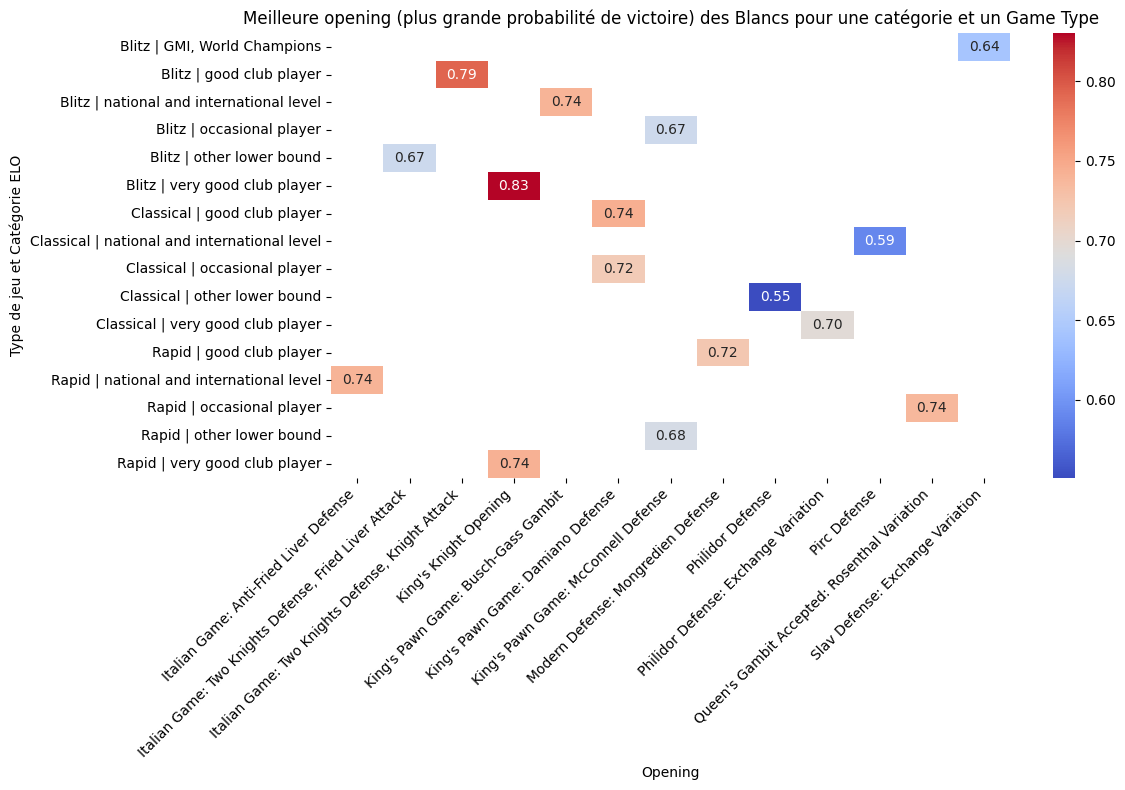

In [74]:
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Meilleure opening (plus grande probabilité de victoire) des Blancs pour une catégorie et un Game Type")
plt.xlabel("Opening")
plt.ylabel("Type de jeu et Catégorie ELO")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Nous pouvons voir que l'opening obtenant un meilleur résultat est généralement différent entre les configurations. Cela pourrait montrer qu'il y a un lien entre la victoire, le type de jeu, le niveau du joueur et l'opening choisi.

##### **Q2b: same question with black. You don't need to write again the same but only the results with black.**

In [75]:
# Calculer le nombre de parties pour chaque configuration
config_game_counts = df_spark_plus.groupBy("Opening", "Black_ELO_category", "Game_type").agg(count("*").alias("Total_games_count"))

In [76]:
# Filtrer les configurations avec plus de 100 parties jouées
# TODO : Voir si on adapte le nombre de parties (autre chose que 100)
filtered_configurations = config_game_counts.filter(col("Total_games_count") > 100)

In [77]:
filtered_df = df_spark_plus.join(filtered_configurations.select("Opening", "Black_ELO_category", "Game_type"), on=["Opening", "Black_ELO_category", "Game_type"], how="inner")

In [78]:
df_black_wins = filtered_df.filter((col("Result") == "0-1") & (col("Game_type").isin(["Blitz", "Rapid", "Classical"])))
df_total_games = filtered_df.filter(col("Game_type").isin(["Blitz", "Rapid", "Classical"]))

In [79]:
df_black_wins_groupby = df_black_wins.groupBy("Opening", "Black_ELO_category", "Game_type").agg(count("*").alias("Black_win_count"))
df_total_games_groupby = df_total_games.groupBy("Opening", "Black_ELO_category", "Game_type").agg(count("*").alias("Total_games_count"))

In [80]:
df_opening_stats = df_black_wins_groupby.join(df_total_games_groupby, on=["Opening", "Black_ELO_category", "Game_type"])
df_opening_stats = df_opening_stats.withColumn("Black_win_probability", col("Black_win_count") / col("Total_games_count"))

Nous affichons maintenant pour chaque catégorie ELO et type de jeu, l'opening (des blancs) permettant le plus de gagner pour les noirs.

In [81]:
window_spec = Window.partitionBy("Black_ELO_category", "Game_type").orderBy(col("Black_win_probability").desc())
best_openings = df_opening_stats.withColumn("rank", rank().over(window_spec))
best_openings = best_openings.filter(col("rank") == 1).select("Black_ELO_category", "Game_type", "Opening", "Black_win_probability") # Rank pour garder les égalités
best_openings.orderBy("Black_ELO_category", "Game_type").show(truncate=False)

+--------------------------------+---------+------------------------------------------------------------+---------------------+
|Black_ELO_category              |Game_type|Opening                                                     |Black_win_probability|
+--------------------------------+---------+------------------------------------------------------------+---------------------+
|GMI, World Champions            |Blitz    |Robatsch (Modern) Defense                                   |0.6190476190476191   |
|good club player                |Blitz    |Grünfeld Defense                                            |0.7099236641221374   |
|good club player                |Classical|King's Pawn Game: Napoleon Attack                           |0.6946564885496184   |
|good club player                |Rapid    |Paleface Attack                                             |0.7378640776699029   |
|national and international level|Blitz    |Caro-Kann Defense: Hillbilly Attack                         

In [82]:
best_openings_pandas = best_openings.toPandas()

In [83]:
best_openings_pandas["GameType_Category"] = (best_openings_pandas["Game_type"] + " | " + best_openings_pandas["Black_ELO_category"])
pivot_table = best_openings_pandas.pivot_table(
    index="GameType_Category",
    columns="Opening",
    values="Black_win_probability"
)

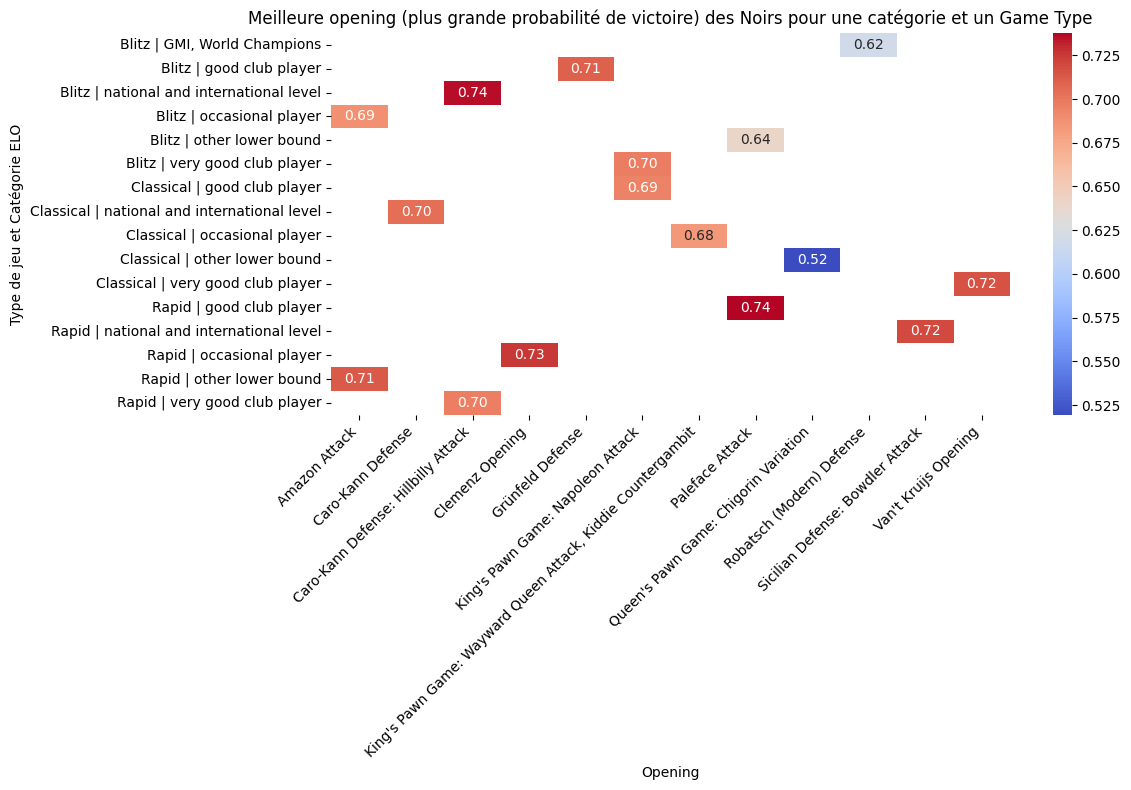

In [84]:
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Meilleure opening (plus grande probabilité de victoire) des Noirs pour une catégorie et un Game Type")
plt.xlabel("Opening")
plt.ylabel("Type de jeu et Catégorie ELO")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Nous pouvons voir que les openings permettant le plus aux noirs de gagner sont différents de ceux permettant aux blancs de gagner. De plus, nous voyons également que l'opening permettant le plus de gagner est différent selon les configurations.

In [85]:
# TODO : iuci faut peut etre dire que opening c'est le coup fait par le blanc (à moins que ce soit plusieurs enchainement s?)

In [86]:
# TODO : ici on peut regarder si on retrouve les memes choses entre noir et blanc*
# C'est différent lol #meilleurConclusionDeLannee

# OK ducoup faut conclure que c'est différent (en meme temps je crois que opening c'est le premier coup de blanc... faut vérifier)

In [87]:
# TODO : Checker à quoi correspondent les openings permettant de gagner (agressif, ...)
# et voir s'il y a un lien entre ces types d'openings et les types de parties

### Question 3

In [88]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import when
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

*Q3: (difficult). Does a line of data in the file predict the outcome of the game (column Result), and with what
probability? In other words, can any of the variables, such as the number of errors (mistakes, blunders, inacurracies,
ts_blunders), the difference in ELO between the two players, etc., explain the outcome (win/loss)? You are free to
define explain as you wish. It can be a correlation, linear or not, or any other relationship that allows this prediction.  
Note that the ELO is itself computed from a probability (normal distribution) of victory depending on the difference
in ELO of the two players. For instance, for a difference of 100 ELO points, the higher ranked player is expected to
win with probability 0.64. For a 200 points difference, it is 0.76.  
As we have more data than the ELO difference, your prediction should be more accurate than that.*

TODO : Dire un résumé de ce qu'on fait dans cette partie

Pour répondre à cette question, nous avons adopté une approche combinant des analyses exploratoires et des techniques de machine learning afin d'évaluer la capacité des variables à expliquer ou prédire le résultat du jeu (colonne *Result*). Cependant, la grande quantité de données disponibles a posé des défis significatifs, notamment en termes de temps d'entraînement pour certains modèles sophistiqués, comme les forêts aléatoires (*Random Forests*) ou les arbres boostés (*Gradient Boosted Trees*), même en réduisant l'échantillon à un pourcentage aléatoire des données.

Face à ces contraintes, nous avons opté pour un modèle de régression multinomiale, qui s'est avéré bien plus rapide à entraîner tout en offrant des performances acceptables sur un sous-échantillon de 1 % des données. Cela a toutefois nécessité une adaptation spécifique de la préparation des données. En parallèle, pour mieux comprendre les relations entre les variables et le résultat, nous avons complété l'analyse par des mesures de corrélation, de covariance et des tableaux de contingence, afin de capturer des liens potentiellement explicatifs ou prédictifs entre les caractéristiques comme les erreurs (*mistakes*, *blunders*, etc.), la différence d'ELO entre les joueurs, et d'autres variables pertinentes.

#### Préparation des données

In [89]:
df_spark_plus.show(5)

+----+--------+---------------+----------+---+----------------+--------------------+------+--------------------+------------+-----------+-------------------+--------+---------------+--------------------+--------------------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+--------------------+-----------+-----------+
|GAME|BlackElo|BlackRatingDiff|      Date|ECO|           Event|             Opening|Result|                Site| Termination|TimeControl|            UTCTime|WhiteElo|WhiteRatingDiff|  Black_ELO_category|  White_ELO_category|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccu

##### **Suppression des colonnes non nécessaires**

Nous allons supprimer certaines colonnes du jeu de données qui ne sont pas pertinentes pour la prédiction de la colonne `Result` et/ou qui pourrait introduire un biais.

<ins>Suppression des colonnes étant des conséquences du résultat:</ins>
* `BlackRatingDiff` :  Variation du classement ELO du joueur noir après la partie
* `WhiteRatingDiff` : Variation du classement ELO du joueur blanc après la partie

Ces colonnes reflètent directement l'issue de la partie et ne peuvent donc pas être utilisées comme des variables explicatives pour prédire le résultat.

TODO : de plus -> gestion de null à pas faire

<ins>Suppression des colonnes n'apportant pas d'informations pertinentes :</ins>
* `GAME` : Identifiant unique de la partie
* `Date`: Date à laquelle la partie a été jouée
* `Site`: URL de la partie  
* `TimeControl` : Temps de jeu en secondes (temps initial + incrément)
* `UTCTime` : Heure à laquelle la partie a été jouée
* `Event` : Evenement où la partie a été jouée

TODO : ici dire que ccertaines de ces infos ne sont pas standardisées c'est pour ça qu'on ls garde pas


Supprimer les colonnes que nous avons calculées (informations redondantes) :
- `Black_ELO_category`
- `White_ELO_category`
- `Avg_ELO_category`

In [ ]:
# TODO ; je supprimerais aussi blakc_moves et white_moves qui sont calculés

In [90]:
# Combien d'instances pour Game_type
df_spark_plus.groupBy("Game_type").count().show()

+--------------+-------+
|     Game_type|  count|
+--------------+-------+
|        Bullet| 806199|
|         Blitz|1812120|
|     Classical| 144677|
|         Rapid| 966569|
|Correspondence|  10344|
+--------------+-------+



In [91]:
# Supprimer Game_type = Correspondance pour pouvoir garder starting_time et increment
# (où les données peuvent être manquantes)
df_spark_plus = df_spark_plus.filter(col("Game_type") != "Correspondence")

In [92]:
# Suppression des colonnes
df_preparation = df_spark_plus.drop("BlackRatingDiff", "WhiteRatingDiff", "GAME", "Date", "Site", "TimeControl", "UTCTime", "Event",  "Black_ELO_category", "White_ELO_category", "Avg_ELO_category")

In [93]:
df_preparation.show(5)

+--------+---+--------------------+------+------------+--------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+-----------+-----------+
|BlackElo|ECO|             Opening|Result| Termination|WhiteElo|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_inferior_moves|Black_ts_moves|White_ts_moves|Black_ts_blunders|White_ts_blunders|Black_ts_mistakes|White_ts_mistake|Black_long_moves|White_long_moves|Black_bad_long_moves|White_bad_long_moves|Game_flips|Game_flips_ts|white_moves|black_moves|
+--------+---+--------------------+------+----

In [94]:
# Combien de valeurs nulles par colonne ?
df_preparation.select([count(when(col(c).isNull(), c)).alias(c) for c in df_preparation.columns]).show()


+--------+---+-------+------+-----------+--------+-------------+---------+---------+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+-----------+-----------+
|BlackElo|ECO|Opening|Result|Termination|WhiteElo|starting_time|increment|Game_type|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_inferior_moves|Black_ts_moves|White_ts_moves|Black_ts_blunders|White_ts_blunders|Black_ts_mistakes|White_ts_mistake|Black_long_moves|White_long_moves|Black_bad_long_moves|White_bad_long_moves|Game_flips|Game_flips_ts|white_moves|black_moves|
+--------+---+-------+------+-----------+--------+-------------+---------+

In [95]:
# Pas de valeur null, c'est parfait

Nous réalisons l'analyse de corrélation, de covariance et des tableaux de contingence avant de finaliser la préparation des données, car la normalisation, la standardisation et l'encodage des données catégorielles peuvent influencer l'interprétation des relations entre les variables. En effet, ces techniques de prétraitement modifient l'échelle ou la représentation des données, ce qui peut fausser les résultats des analyses de corrélation ou de covariance si elles sont effectuées après ces transformations.


Pourquoi cela est important :

Corrélation et Covariance :
- La corrélation mesure la force et la direction d'une relation linéaire entre deux variables. Elle peut être affectée par la mise à l'échelle des données (par exemple, en cas de normalisation ou standardisation). Si ces transformations sont faites après l'analyse de corrélation, il devient plus difficile d'interpréter les relations d'origine.
- La covariance, bien que similaire à la corrélation, n'est pas dimensionnée. Elle peut être influencée par les unités de mesure des variables, ce qui peut fausser l'interprétation si les données ne sont pas préparées correctement.
- **NB** : Nous avons tout de même besoin d'encoder Result en Result_index avant l'analyse de corrélation et de covariance.

Encodage des données catégorielles :
- Lorsque nous avons des colonnes catégorielles, l'encodage (comme le One-Hot Encoding ou le Target Encoding) peut introduire des relations implicites ou artificielles entre les variables. Cela peut affecter la façon dont les relations entre les catégories sont perçues dans les analyses de corrélation ou de covariance. Il est donc important d'encodé ces variables avant d'exécuter l'analyse, pour éviter d'introduire de fausses relations ou de perdre des informations importantes.

### Table de contingence

In [98]:
# Sélectionner toutes les colonnes catégorielles dans le DataFrame
cat_columns = [col for col, dtype in df_preparation.dtypes if dtype == 'string']
cat_columns

['ECO', 'Opening', 'Result', 'Termination', 'Game_type']

Contingency Table for ECO and Result :
+---+-------+-----+
|ECO| Result|count|
+---+-------+-----+
|C61|    1-0| 3052|
|B07|1/2-1/2| 1628|
|E40|    0-1|  273|
|B26|    1-0|  135|
|C40|1/2-1/2|  970|
|A09|    0-1| 1496|
|B76|    0-1| 1109|
|E04|1/2-1/2|   35|
|E68|1/2-1/2|   15|
|E85|    1-0|  103|
|C99|    0-1|   34|
|B01|    1-0|78801|
|D83|    0-1|   63|
|A61|    0-1|  113|
|C44|    1-0|27712|
|B53|    1-0| 1854|
|C22|1/2-1/2|  256|
|E40|1/2-1/2|   30|
|A67|    1-0|   81|
|E31|    0-1|   15|
+---+-------+-----+
only showing top 20 rows



<Figure size 1000x600 with 0 Axes>

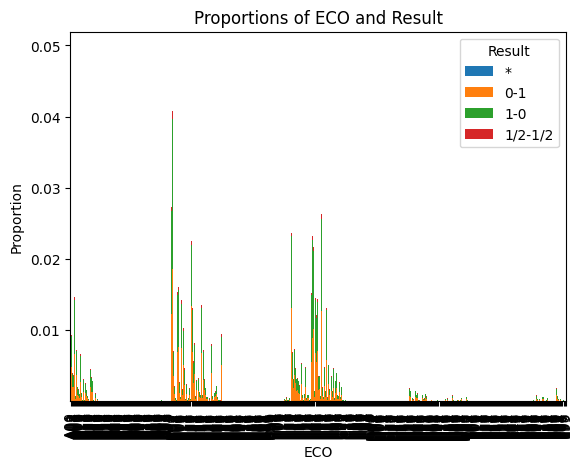

Contingency Table for Opening and Result :
+--------------------+-------+-----+
|             Opening| Result|count|
+--------------------+-------+-----+
|Sicilian Defense:...|    1-0| 1433|
|    Budapest Defense|    0-1|  453|
|     Blackmar Gambit|    0-1| 1980|
|Italian Game: Two...|    1-0| 3434|
|King's Knight Ope...|    0-1| 1080|
|Zukertort Opening...|    0-1| 1553|
|Center Game: Berg...|    1-0|  667|
|King's Gambit, Fa...|    0-1|  357|
|Sicilian Defense:...|    0-1|   94|
|Nimzowitsch-Larse...|    1-0|   65|
|Scotch Game: Relf...|    0-1|  110|
|Dutch Defense: Le...|    0-1|  103|
|       Czech Defense|1/2-1/2|   40|
|Evans Gambit, Ala...|    1-0|    8|
|King's Gambit Dec...|1/2-1/2|   12|
|King's Gambit Acc...|1/2-1/2|   22|
|Scandinavian Defe...|    0-1|   62|
|      Canard Opening|1/2-1/2|   23|
|Sicilian Defense:...|    0-1|   15|
|French Defense: R...|1/2-1/2|   13|
+--------------------+-------+-----+
only showing top 20 rows



<Figure size 1000x600 with 0 Axes>

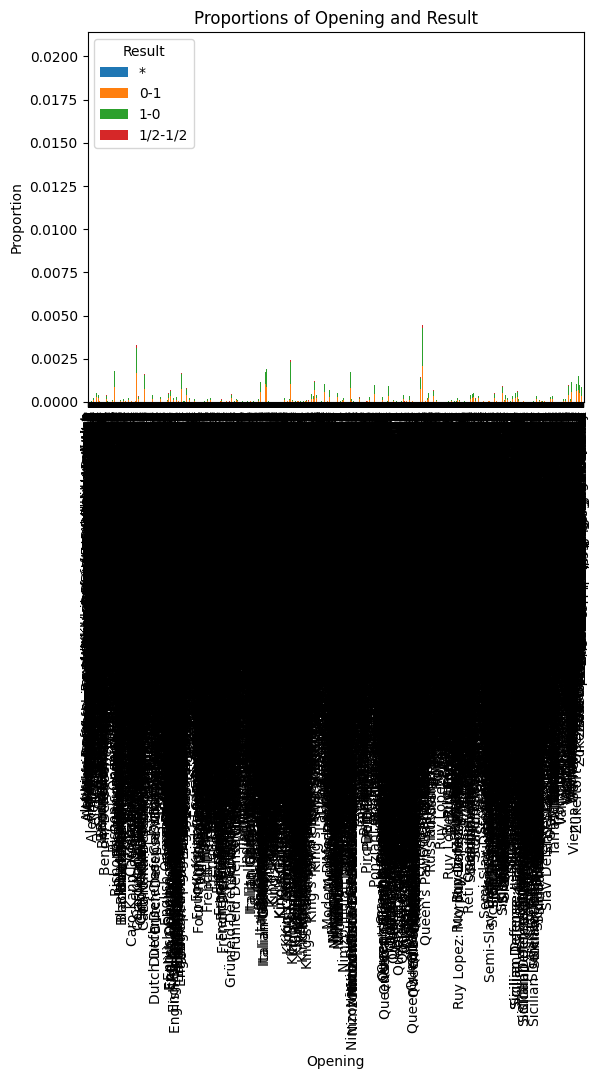

Contingency Table for Termination and Result :
+----------------+-------+-------+
|     Termination| Result|  count|
+----------------+-------+-------+
|    Time forfeit|    1-0| 432268|
|          Normal|1/2-1/2| 101932|
|          Normal|    1-0|1426411|
|    Time forfeit|1/2-1/2|   6966|
|Rules infraction|    0-1|    168|
|       Abandoned|    1-0|      2|
|Rules infraction|    1-0|    159|
|          Normal|    0-1|1331420|
|       Abandoned|      *|     72|
|    Time forfeit|    0-1| 430167|
+----------------+-------+-------+



<Figure size 1000x600 with 0 Axes>

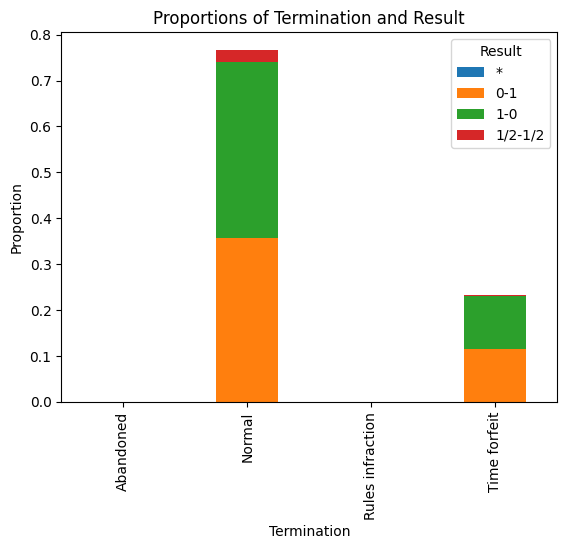

Contingency Table for Game_type and Result :
+---------+-------+------+
|Game_type| Result| count|
+---------+-------+------+
|Classical|      *|     5|
|    Rapid|    1-0|479542|
|    Blitz|1/2-1/2| 57762|
|    Blitz|    0-1|850624|
|Classical|    0-1| 67652|
|    Blitz|      *|    37|
|   Bullet|      *|     8|
|   Bullet|    1-0|404537|
|Classical|    1-0| 71064|
|    Rapid|    0-1|453532|
|   Bullet|    0-1|389947|
|    Rapid|      *|    22|
|   Bullet|1/2-1/2| 11707|
|    Blitz|    1-0|903697|
|    Rapid|1/2-1/2| 33473|
|Classical|1/2-1/2|  5956|
+---------+-------+------+



<Figure size 1000x600 with 0 Axes>

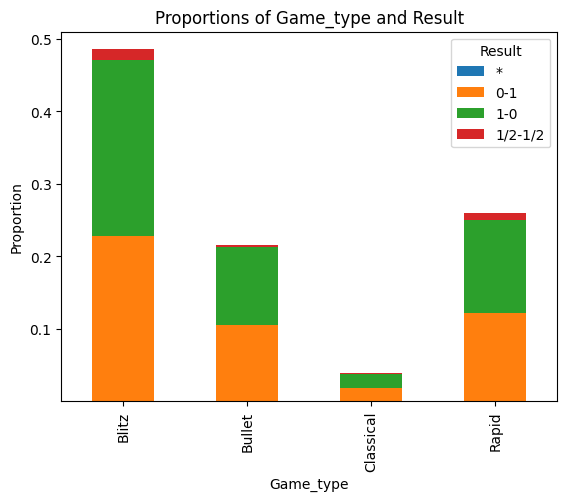

Summary for ECO:
   ECO   Result  count  Proportion
0  C61      1-0   3052    0.000818
1  B07  1/2-1/2   1628    0.000437
2  E40      0-1    273    0.000073
3  B26      1-0    135    0.000036
4  C40  1/2-1/2    970    0.000260


Summary for Opening:
                                    Opening Result  count  Proportion
0      Sicilian Defense: Accelerated Dragon    1-0   1433    0.000384
1                          Budapest Defense    0-1    453    0.000121
2                           Blackmar Gambit    0-1   1980    0.000531
3         Italian Game: Two Knights Defense    1-0   3434    0.000921
4  King's Knight Opening: Konstantinopolsky    0-1   1080    0.000290


Summary for Termination:
        Termination   Result    count  Proportion
0      Time forfeit      1-0   432268    0.115903
1            Normal  1/2-1/2   101932    0.027331
2            Normal      1-0  1426411    0.382460
3      Time forfeit  1/2-1/2     6966    0.001868
4  Rules infraction      0-1      168    0.000045


S

In [110]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

# Fonction pour créer la table de contingence
def create_contingency_table(data, col1, col2):
    return data.groupBy(col1, col2).count()

# Liste pour stocker les résultats
contingency_tables = []

# Boucle pour générer la table de contingence pour chaque paire de colonnes catégorielles
for col in cat_columns:
    # Créer la table de contingence
    contingency_table = create_contingency_table(df_preparation, col, 'Result')
    print(f"Contingency Table for {col} and Result :")
    contingency_table.show()

    # Convertir la table de contingence en DataFrame Pandas pour l'analyse
    contingency_df = contingency_table.toPandas()

    # Calculer les proportions de chaque combinaison par rapport au total
    contingency_df['Proportion'] = contingency_df['count'] / contingency_df['count'].sum()

    # Ajouter la table de contingence à la liste
    contingency_tables.append({
        "Variable": col,
        "Contingency Table": contingency_df
    })

    # Visualisation de la table de contingence
    plt.figure(figsize=(10, 6))
    contingency_df.pivot(index=col, columns='Result', values='Proportion').plot(kind='bar', stacked=True)
    plt.title(f"Proportions of {col} and Result")
    plt.xlabel(col)
    plt.ylabel("Proportion")
    plt.legend(title="Result")
    plt.show()

# Résumé des tables de contingence
for result in contingency_tables:
    print(f"Summary for {result['Variable']}:")
    print(result['Contingency Table'].head())  # Affiche les premières lignes pour une vue d'ensemble
    print("\n")


In [ ]:
# TODO analyse : on voit rien de significatif ? 50 50 ?

In [114]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt

# Sélectionner toutes les colonnes catégorielles dans le DataFrame qui ne sont pas Result
cat_columns = [col for col, dtype in df_preparation.dtypes if dtype == 'string' and col != 'Result']

# Indexation des colonnes catégorielles
indexers = [
    StringIndexer(inputCol=col_name, outputCol=col_name + "_index")
    for col_name in cat_columns + ['Result']
]

# Créer un VectorAssembler pour assembler les colonnes en un vecteur
assembler = VectorAssembler(
    inputCols=[col_name + "_index" for col_name in cat_columns],
    outputCol="features"
)

# Créer le pipeline
pipeline = Pipeline(stages=indexers + [assembler])

# Appliquer le pipeline pour transformer les données
df_transformed = pipeline.fit(df_preparation).transform(df_preparation)

# Liste pour stocker les résultats
chi_results = []

# Boucle pour générer la table de contingence et effectuer le test chi-deux pour chaque paire de colonnes catégorielles
for col in cat_columns:
    # Créer un DataFrame avec les colonnes à tester (en utilisant "features" comme colonne d'entrée)
    df_chi = df_transformed.select("features", col + "_index")

    # Effectuer le test de chi-deux
    chi_result = ChiSquareTest.test(df_chi, "features", col + "_index").head()

    # Afficher le résultat du test de chi-deux
    print(f"Chi-Square Test for {col} and Result:")
    print(f"Chi-Square Statistic: {chi_result[0]}, p-value: {chi_result[1]}")

    # Ajouter les résultats dans la liste
    chi_results.append({
        "Variable": col,
        "Chi-Square Statistic": chi_result[0],
        "p-value": chi_result[1]
    })

# Créer un DataFrame pour les résultats
chi_results_df = spark.createDataFrame(chi_results)

# Afficher les résultats
chi_results_df.show()



Chi-Square Test for ECO and Result:
Chi-Square Statistic: [0.0,0.0,0.0,0.0], p-value: [241081, 1368908, 1473, 1473]
Chi-Square Test for Opening and Result:
Chi-Square Statistic: [0.0,0.0,0.0,0.0], p-value: [1368908, 7772944, 8364, 8364]
Chi-Square Test for Termination and Result:
Chi-Square Statistic: [0.0,0.0,0.0,0.0], p-value: [1473, 8364, 9, 9]
Chi-Square Test for Game_type and Result:
Chi-Square Statistic: [0.0,0.0,0.0,0.0], p-value: [1473, 8364, 9, 9]
+--------------------+-----------+--------------------+
|Chi-Square Statistic|   Variable|             p-value|
+--------------------+-----------+--------------------+
|   [0.0,0.0,0.0,0.0]|        ECO|[241081, 1368908,...|
|   [0.0,0.0,0.0,0.0]|    Opening|[1368908, 7772944...|
|   [0.0,0.0,0.0,0.0]|Termination|  [1473, 8364, 9, 9]|
|   [0.0,0.0,0.0,0.0]|  Game_type|  [1473, 8364, 9, 9]|
+--------------------+-----------+--------------------+



In [ ]:
# TODO : analyse

Les résultats des tests du chi-deux que vous avez obtenus montrent les valeurs statistiques et les p-values pour différentes variables catégorielles par rapport à la variable cible Result. Voici une analyse détaillée des résultats pour chaque variable :

1. ECO et Result
Chi-Square Statistic : [0.0, 0.0, 0.0, 0.0]
p-value : [241081, 1368908, 1473, 1473]
L'absence de valeurs supérieures à zéro dans les statistiques du chi-deux (valeurs égales à 0) signifie qu'il n'y a pas d'association entre les catégories de la variable ECO et la variable cible Result. Cela suggère que les différentes catégories de ECO sont indépendantes de Result, du moins selon ce test.

Les p-values élevées (241081, 1368908, etc.) confirment l'absence de relation statistique significative entre les deux variables, car une p-value élevée (généralement > 0.05) indique une faible probabilité que l'association observée soit due au hasard.

2. Opening et Result
Chi-Square Statistic : [0.0, 0.0, 0.0, 0.0]
p-value : [1368908, 7772944, 8364, 8364]
Comme pour ECO, les statistiques du chi-deux de Opening sont égales à 0, ce qui indique qu'il n'y a aucune association significative entre cette variable et Result. Les p-values très élevées renforcent cette conclusion : la probabilité que l'absence d'association soit due au hasard est très faible.

3. Termination et Result
Chi-Square Statistic : [0.0, 0.0, 0.0, 0.0]
p-value : [1473, 8364, 9, 9]
Ici encore, la statistique du chi-deux est nulle, ce qui suggère qu'il n'y a pas d'association significative entre Termination et Result. Cependant, les p-values sont légèrement plus petites (9 et 8364), ce qui peut indiquer des zones où une association pourrait potentiellement être présente, mais elles restent suffisamment élevées pour indiquer qu'il n'y a pas de relation forte.

4. Game_type et Result
Chi-Square Statistic : [0.0, 0.0, 0.0, 0.0]
p-value : [1473, 8364, 9, 9]
Comme les résultats pour Termination, la statistique du chi-deux est de 0, ce qui ne montre aucune association significative entre Game_type et Result. Les p-values sont similaires à celles de Termination, ce qui confirme qu'il n'y a pas de lien important entre ces variables.

Conclusion générale :
Les résultats montrent que pour ces variables (ECO, Opening, Termination, Game_type), les tests de chi-deux ne révèlent aucune relation statistiquement significative avec la variable Result. En effet, les statistiques du chi-deux sont toutes nulles (0.0), ce qui suggère que la distribution des catégories de ces variables est indépendante de la variable cible Result. Les p-values élevées corroborent ce constat, car une p-value élevée indique que l'on ne peut pas rejeter l'hypothèse nulle (indépendance entre les variables).

Cela signifie que aucune des variables testées (ECO, Opening, Termination, Game_type) n'a de lien évident avec Result dans votre jeu de données, du moins selon le test statistique du chi-deux effectué.

On encode Result en colonne numérique.

In [117]:
# Nombre de valeurs par Result
df_preparation.groupBy("Result").count().show()

+-------+-------+
| Result|  count|
+-------+-------+
|      *|     72|
|1/2-1/2| 108898|
|    1-0|1858840|
|    0-1|1761755|
+-------+-------+



In [120]:
from pyspark.sql.functions import col

df_preparation = df_preparation.filter(col("Result") != "*")

In [121]:
# Result : colonne cible, 3 valeurs possibles

df_preparation = df_preparation.withColumn(
    "Result_index",
    when(col("Result") == "1-0", 0)
    .when(col("Result") == "0-1", 2)
    .when(col("Result") == "1/2-1/2", 1) # nul "moyenne" des deux autres scénarios
)

# Vérification
df_preparation.select("Result", "Result_index").distinct().show()

+-------+------------+
| Result|Result_index|
+-------+------------+
|    0-1|           2|
|    1-0|           0|
|1/2-1/2|           1|
+-------+------------+



Il y a seulement 72 valeurs indéfini dans la colonnes Result, nous allons supprimer ces parties (ces lignes), car elles n'ont pas d'intérêts et sont en trop faible nombre pour apporter un réel résultat à notre analyse.

### Corrélation

La corrélation mesure la force et la direction de la relation linéaire entre deux variables.

- Une corrélation proche de +1 ou -1 indique une forte relation linéaire.
- Une corrélation proche de 0 indique peu ou pas de relation linéaire.


In [122]:
# Quelles sont les colonnes numériques ?
numeric_cols = [col[0] for col in df_preparation.dtypes if col[1] in ["int", "double"]]
print(f'Les colonnes numériques sont : {numeric_cols}')

Les colonnes numériques sont : ['BlackElo', 'WhiteElo', 'starting_time', 'increment', 'Total_moves', 'Black_blunders', 'White_blunders', 'Black_mistakes', 'White_mistakes', 'Black_inaccuracies', 'White_inaccuracies', 'Black_inferior_moves', 'White_inferior_moves', 'Black_ts_moves', 'White_ts_moves', 'Black_ts_blunders', 'White_ts_blunders', 'Black_ts_mistakes', 'White_ts_mistake', 'Black_long_moves', 'White_long_moves', 'Black_bad_long_moves', 'White_bad_long_moves', 'Game_flips', 'Game_flips_ts', 'white_moves', 'black_moves', 'Result_index']


In [125]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Assembler les colonnes numériques en un seul vecteur
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_features")
assembled_data = assembler.transform(df_preparation)

# Calculer la matrice de corrélation
correlation_matrix = Correlation.corr(assembled_data, "numeric_features").head()[0]

# Convertir en DataFrame pour un affichage clair
correlation_array = np.array(correlation_matrix.toArray())
correlation_df = pd.DataFrame(correlation_array, columns=numeric_cols, index=numeric_cols)
print(correlation_df)

                      BlackElo  WhiteElo  starting_time  increment  \
BlackElo              1.000000  0.910094       0.008177  -0.007045   
WhiteElo              0.910094  1.000000       0.007926  -0.006531   
starting_time         0.008177  0.007926       1.000000   0.437907   
increment            -0.007045 -0.006531       0.437907   1.000000   
Total_moves           0.190490  0.187216       0.031237   0.019891   
Black_blunders       -0.194336 -0.175368      -0.034803  -0.033971   
White_blunders       -0.179486 -0.197494      -0.035166  -0.033524   
Black_mistakes       -0.015877  0.000017      -0.003054  -0.010270   
White_mistakes        0.005894 -0.009455      -0.005331  -0.010534   
Black_inaccuracies    0.070694  0.084842      -0.013919  -0.011425   
White_inaccuracies    0.079578  0.059822      -0.009121  -0.008592   
Black_inferior_moves -0.063166 -0.039434      -0.023877  -0.026209   
White_inferior_moves -0.040511 -0.065927      -0.022844  -0.024637   
Black_ts_moves      

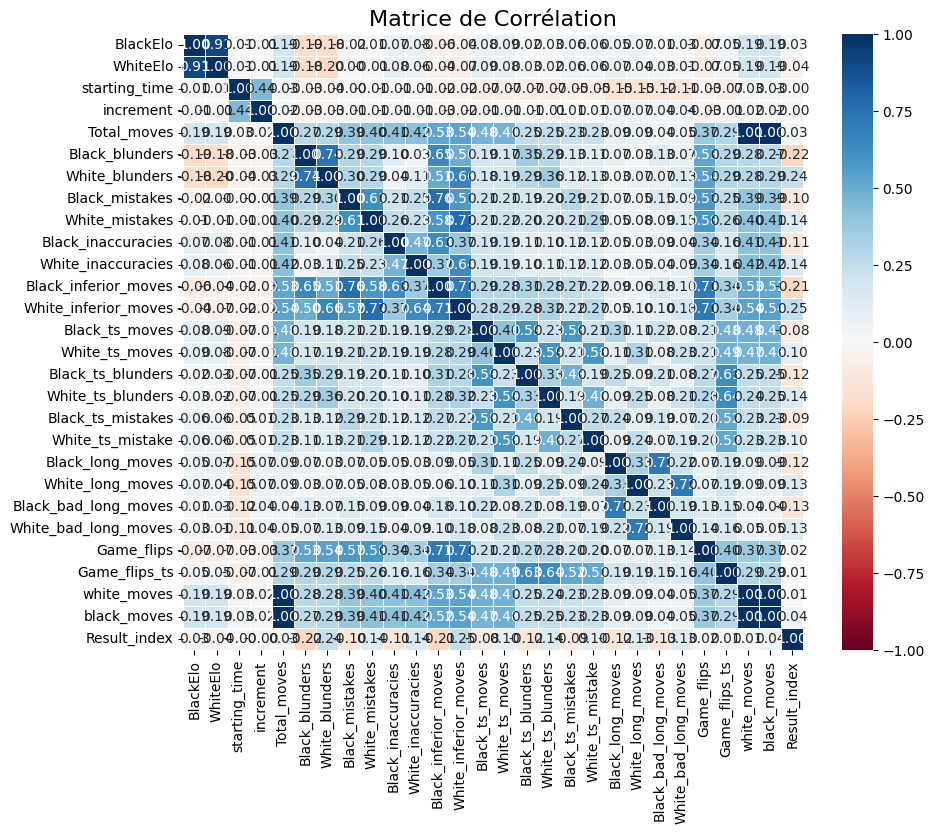

In [129]:
# Créer une heatmap avec seaborn pour une meilleure visualisation
plt.figure(figsize=(10, 8))

# Utiliser une palette de couleurs allant de -1 à 1 (avec 0 en blanc)
sns.heatmap(correlation_df, annot=True, cmap='RdBu', center=0, vmin=-1, vmax=1, fmt=".2f", linewidths=0.5)

# Ajouter un titre
plt.title("Matrice de Corrélation", fontsize=16)

# Afficher la heatmap
plt.show()

              BlackElo  WhiteElo  starting_time  increment  Total_moves  \
Result_index  0.029181 -0.041489      -0.001041  -0.000142     0.027271   

              Black_blunders  White_blunders  Black_mistakes  White_mistakes  \
Result_index       -0.216912        0.237662       -0.104876        0.135857   

              Black_inaccuracies  ...  White_ts_mistake  Black_long_moves  \
Result_index           -0.111273  ...          0.103767         -0.120649   

              White_long_moves  Black_bad_long_moves  White_bad_long_moves  \
Result_index          0.126939             -0.126236              0.131903   

              Game_flips  Game_flips_ts  white_moves  black_moves  \
Result_index    0.021913       0.009755     0.010808     0.043709   

              Result_index  
Result_index           1.0  

[1 rows x 28 columns]


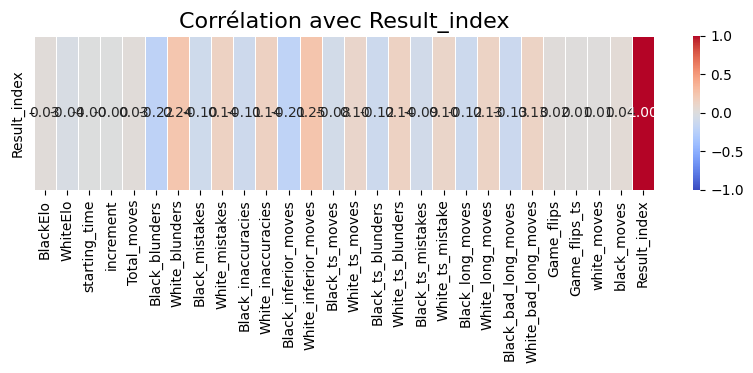

In [130]:
# Sélectionner uniquement la dernière ligne (ici 'Result_index')
result_corr = correlation_df.loc['Result_index']

# Créer un DataFrame avec une seule ligne pour le plot
result_corr_df = result_corr.to_frame().T  # Transforme la Série en DataFrame pour la visualisation

# Afficher la dernière ligne sélectionnée
print(result_corr_df)

# Créer une heatmap avec seaborn pour une meilleure visualisation
plt.figure(figsize=(10, 2))  # Ajuster la taille pour ne montrer qu'une seule ligne

# Utiliser une palette de couleurs allant de -1 à 1 (avec 0 en blanc)
sns.heatmap(result_corr_df, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, fmt=".2f", linewidths=0.5)

# Ajouter un titre
plt.title("Corrélation avec Result_index", fontsize=16)

# Afficher la heatmap
plt.show()

In [ ]:
# TODO : analyse (se focus surtout sur la ligne correspondant à result_index

### Covariance

- Une covariance positive indique que les deux variables augmentent ensemble.
- Une covariance négative indique qu'une variable augmente tandis que l'autre diminue.

In [134]:
# Liste des colonnes numériques sauf "Result"
numeric_cols_without_result = [col for col in numeric_cols if col != 'Result_index']

# Calculer la covariance entre 'Result' et chaque autre colonne numérique
cov_result = []
for col in numeric_cols_without_result:
    print(f"Calcul de {col}")
    covariance = data.stat.cov('Result_index', col)
    cov_result.append(covariance)

# Créer un DataFrame pour afficher les résultats
cov_result_df = pd.DataFrame(cov_result, columns=['Covariance'], index=numeric_cols_without_result)

# Afficher les covariances
print(cov_result_df)


Calcul de BlackElo
Calcul de WhiteElo
Calcul de starting_time
Calcul de increment
Calcul de Total_moves
Calcul de Black_blunders
Calcul de White_blunders
Calcul de Black_mistakes
Calcul de White_mistakes
Calcul de Black_inaccuracies
Calcul de White_inaccuracies
Calcul de Black_inferior_moves
Calcul de White_inferior_moves
Calcul de Black_ts_moves
Calcul de White_ts_moves
Calcul de Black_ts_blunders
Calcul de White_ts_blunders
Calcul de Black_ts_mistakes
Calcul de White_ts_mistake
Calcul de Black_long_moves
Calcul de White_long_moves
Calcul de Black_bad_long_moves
Calcul de White_bad_long_moves
Calcul de Game_flips
Calcul de Game_flips_ts
Calcul de white_moves
Calcul de black_moves
                      Covariance
BlackElo                9.880810
WhiteElo              -14.049130
starting_time          -0.416678
increment              -0.000598
Total_moves             0.717455
Black_blunders         -0.419101
White_blunders          0.462271
Black_mistakes         -0.241101
White_mistake

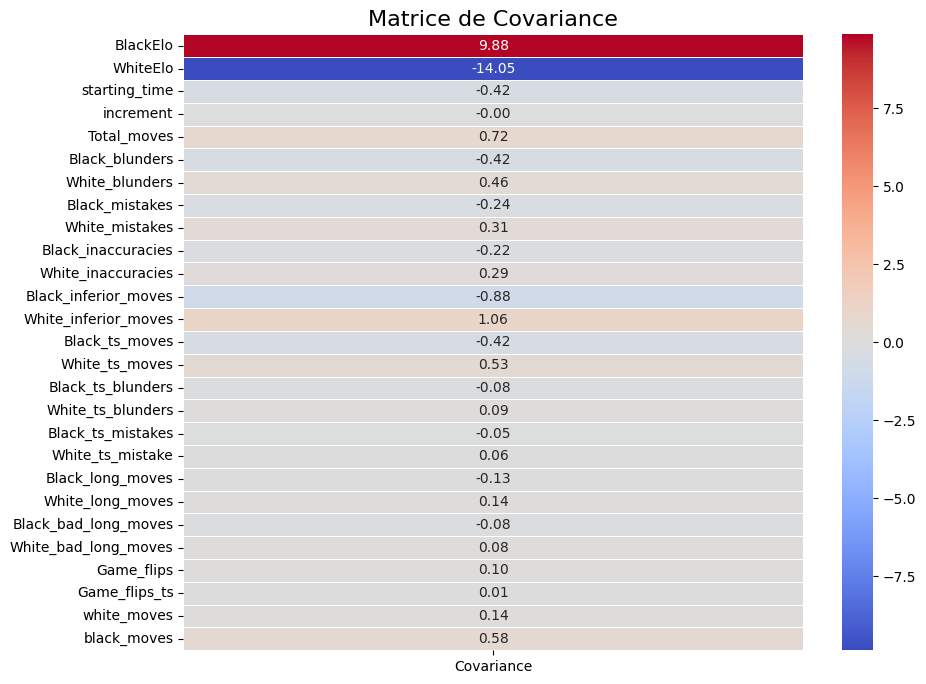

In [137]:
# Créer une heatmap pour la matrice de covariance
plt.figure(figsize=(10, 8))  # Ajuster la taille pour mieux visualiser

# Utiliser une palette de couleurs pour les covariances
sns.heatmap(cov_result_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, center=0, vmin=-cov_result_df.max().max(), vmax=cov_result_df.max().max())

# Ajouter un titre
plt.title("Matrice de Covariance", fontsize=16)

# Afficher la heatmap
plt.show()

In [ ]:
# TODO analyse des résultats
# déjà normal le niveau de ELO impact
# ensuite les inferior moves (Resulty = 0 si blanc gagne, 1 égalité 2 perd)
# on white à 1.06 et black à -0.88
# ?
# les ts moves impactent plus que blunders ou mistakes
#

##### **Encodage des colonnes non numériques**

Un véritable défi dans la préparation des données a été l'encodage des colonnes catégorielles, notamment celles avec un très grand nombre de catégories distinctes. Dans de tels cas, utiliser un encodage classique comme le one-hot encoding aurait été impraticable. Cela aurait non seulement multiplié la taille des données de manière exponentielle, mais également introduit des matrices très clairsemées et difficiles à exploiter efficacement dans les modèles.

Pour surmonter cette limitation, nous avons opté pour le target encoding, une approche plus adaptée. Cette méthode consiste à remplacer chaque catégorie par une valeur numérique calculée en fonction de la cible (par exemple, le taux moyen de victoire pour chaque catégorie). Cela nous a permis de conserver l'information tout en réduisant significativement la complexité des données et en améliorant leur utilisabilité dans les modèles d’apprentissage.

In [138]:
# Observation des types des colonnes pour savoir comment les traiter
schema = df_preparation.schema
columns_by_type = defaultdict(list)

for field in schema:
    columns_by_type[str(field.dataType)].append(field.name)

for data_type, columns in columns_by_type.items():
    print(f"Type: {data_type}")
    print(f"Columns: {columns}\n")

Type: IntegerType()
Columns: ['BlackElo', 'WhiteElo', 'starting_time', 'increment', 'Total_moves', 'Black_blunders', 'White_blunders', 'Black_mistakes', 'White_mistakes', 'Black_inaccuracies', 'White_inaccuracies', 'Black_inferior_moves', 'White_inferior_moves', 'Black_ts_moves', 'White_ts_moves', 'Black_ts_blunders', 'White_ts_blunders', 'Black_ts_mistakes', 'White_ts_mistake', 'Black_long_moves', 'White_long_moves', 'Black_bad_long_moves', 'White_bad_long_moves', 'Game_flips', 'Game_flips_ts', 'Result_index']

Type: StringType()
Columns: ['ECO', 'Opening', 'Result', 'Termination', 'Game_type']

Type: DoubleType()
Columns: ['white_moves', 'black_moves']



Il y a 5 colonnes de type chaine de caractères, nous allons les encoder afin de pouvoir les utiliser dans nos prédictions.

In [ ]:
# Combien de données différentes contiennent chacune de ces colonnes ?

for column in columns_by_type["StringType()"]:
  distinct_count = df_preparation.select(column).distinct().count()
  print(f"Nombre de valeurs distinctes pour la colonne '{column}': {distinct_count}")

Nombre de valeurs distinctes pour la colonne 'ECO': 492
Nombre de valeurs distinctes pour la colonne 'Opening': 2789
Nombre de valeurs distinctes pour la colonne 'Result': 3


Nous allons gérer ces colonnes de façons différentes, en fonction de leur nombre de valeurs possibles et de leur type.

* `Result` : Colonne à prédire (déjà encodée avant l'analyse par corrélation)
* `ECO`, `Opening` : Beaucoup de valeurs possibles
* `Termination`, `Game_type` : Peu de valeurs


In [ ]:
# Supprimer alors Result
df_preparation = df_preparation.drop("Result")

In [ ]:
# Game_type : 4 valeurs, pseudo relation d'ordre
df_preparation = df_preparation.withColumn(
    "Game_type_encoded",
    when(col("Game_type") == "Bullet", 1)
    .when(col("Game_type") == "Blitz", 2)
    .when(col("Game_type") == "Rapid", 3)
    .when(col("Game_type") == "Classical", 4)
)

# vérifier
df_preparation.select("Game_type", "Game_type_encoded").distinct().show()

In [ ]:
# Supprimer Game_type
df_preparation = df_preparation.drop("Game_type")

In [ ]:
# copy du df pour pas tout perdre
data = df_preparation

In [ ]:
# Eco et Opening : beaucoup de valeurs possibles
# On ne peut pas faire un One-Hot encoding -> cela créerait trop de colonnes
# Label encoding pourrait introduire un biais implicite d'ordre (en fonction du modèle choisi)
# On va donc utiliser un Target encoding

# TODO : blabla explicatif
# Le target encoding (encodage cible) est une méthode d'encodage
# utilisée principalement pour les colonnes catégoriques avec de
# nombreuses valeurs uniques. Au lieu de transformer chaque catégorie
# en une variable distincte (comme avec le one-hot encoding),
# on associe chaque catégorie à une statistique calculée à partir
# de la cible (par exemple, la moyenne de la variable cible pour
# cette catégorie).
# Target encoding résume l'information de nombreuses catégories dans une seule colonne, ce qui réduit la mémoire nécessaire pour stocker et traiter les données.
# Target encoding transforme les colonnes catégoriques en valeurs numériques basées sur la cible, ce qui est mieux adapté aux modèles qui fonctionnent mal avec des données catégoriques brutes (comme les modèles linéaires ou les arbres de décision).

from pyspark.sql.functions import col, mean

# Target encoding pour "Opening"
avg_opening_result = data.groupBy("Opening").agg(mean("Result_index").alias("opening_score"))
data = data.join(avg_opening_result, on="Opening", how="left")

# Target encoding pour "Eco"
avg_eco_result = data.groupBy("Eco").agg(mean("Result_index").alias("eco_score"))
data = data.join(avg_eco_result, on="Eco", how="left")

# Vérification des colonnes ajoutées
data.select("Opening", "opening_score", "Eco", "eco_score").show(10)

In [ ]:
# Supprimer Opening et Eco
data = data.drop("Opening", "Eco")

In [ ]:
# Quelles sont les valeurs de Termination ?
data.select("Termination").distinct().show()

In [ ]:
# Termination : 4 valeurs possibles
# One hot encoding pour éviter relations d'ordre implicite

# créer Termination_Abandoned, Termination_Rules_infraction,
# Termination_Time_forfeit
# Termination_Normal

data = data.withColumn(
    "Termination_Abandoned",
    when(col("Termination") == "Abandoned", 1)
    .otherwise(0)
)

data = data.withColumn(
    "Termination_Rules_infraction",
    when(col("Termination") == "Rules infraction", 1)
    .otherwise(0)
)

data = data.withColumn(
    "Termination_Time_forfeit",
    when(col("Termination") == "Time forfeit", 1)
    .otherwise(0)
)

data = data.withColumn(
    "Termination_Normal",
    when(col("Termination") == "Normal", 1)
    .otherwise(0)
)

# Afficher Termination et les 4 colonnes créées
data.select("Termination", "Termination_Abandoned", "Termination_Rules_infraction", "Termination_Time_forfeit", "Termination_Normal").show(10)

In [ ]:
# Supprimer Termination
data = data.drop("Termination")

In [ ]:
# Vérifier les colonnes
data.printSchema()

##### **Normalisation des données**

In [ ]:
# Quelles sont les colonnes numériques ? (normalement toutes)
numeric_cols = [col[0] for col in data.dtypes if col[1] in ["int", "double"]]
print(f'Les colonnes numériques sont : {numeric_cols}')

# Quelles sont les colonnes non numériques ?
non_numeric_cols = [col[0] for col in data.dtypes if col[1] not in ["int", "double"]]
print(f'Les colonnes non numériques sont : {non_numeric_cols}')

In [ ]:
# from pyspark.ml.feature import StandardScaler, VectorAssembler
# from pyspark.sql.functions import col

# # Étape 1 : Sélectionner les colonnes numériques à standardiser
# numeric_cols = ["Black_ELO", "White_ELO", "Avg_ELO", "mistakes", "blunders", "inaccuracies", "ts_blunders"]

# # Étape 2 : Combiner les colonnes numériques dans un seul vecteur pour la standardisation
# assembler = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_features")
# data = assembler.transform(data)

# # Étape 3 : Standardiser les données
# scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_features", withMean=True, withStd=True)
# scaler_model = scaler.fit(data)
# data = scaler_model.transform(data)

# # Étape 4 : (Optionnel) Convertir les données standardisées en colonnes séparées
# from pyspark.ml.functions import vector_to_array

# # Transformer le vecteur en colonnes séparées
# data = data.withColumn("scaled_features_array", vector_to_array(col("scaled_features")))

# # Réattribuer chaque colonne standardisée à son nom d'origine
# for i, col_name in enumerate(numeric_cols):
#     data = data.withColumn(f"{col_name}_scaled", col("scaled_features_array")[i])

# # Étape 5 : Supprimer les colonnes intermédiaires si nécessaire
# data = data.drop("numeric_features", "scaled_features", "scaled_features_array")

# # Afficher un aperçu des données
# data.select(*[f"{col}_scaled" for col in numeric_cols]).show(5)


In [ ]:
# # Normalisation des colonnes numériques
# numeric_cols = [
#     'Total_moves', 'Black_blunders', 'White_blunders', 'Black_mistakes', 'White_mistakes',
#     'Black_inaccuracies', 'White_inaccuracies', 'Black_inferior_moves', 'White_inferior_moves',
#     'Black_ts_moves', 'White_ts_moves', 'Black_ts_blunders', 'White_ts_blunders',
#     'Black_ts_mistakes', 'White_ts_mistake', 'Black_long_moves', 'White_long_moves',
#     'Black_bad_long_moves', 'White_bad_long_moves', 'Game_flips', 'Game_flips_ts',
#     'white_moves', 'black_moves'
# ]

# assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features_raw")
# df_prepared = assembler.transform(df_preparation)

# scaler = MinMaxScaler(inputCol="features_raw", outputCol="scaled_features")
# scaler_model = scaler.fit(df_prepared)
# df_prepared = scaler_model.transform(df_prepared)

In [ ]:
# toutes les colonnes sauf "Result_index"
feature_columns = data.columns
feature_columns.remove("Result_index")

In [ ]:
# Combinaison des colonnes finales
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_final = assembler.transform(data)

# ARCHIVE :
# feature_cols = ['scaled_features', 'ECO_index', 'Opening_index'] + [f"{col}_ohe" for col in columns_to_encode]
# final_assembler = VectorAssembler(inputCols=feature_cols, outputCol="final_features")
# df_prepared = final_assembler.transform(df_prepared)

# # Suppression des colonnes inutiles
# cols_to_drop = ['ECO', 'Opening', 'Result', 'Termination', 'Black_ELO_category', 'White_ELO_category', 'Game_type',
#                 'features_raw', 'scaled_features'] + numeric_cols
# df_prepared = df_prepared.drop(*cols_to_drop)

In [ ]:
df_final.show(5)

In [ ]:
df_features = df_final.select("features", "Result_index")

### Train test

In [ ]:
# Diviser les données en 80% pour l'entrainement et 20% pour le test
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# SI c'est vraiment trop chiant à réduire -> CORRÉLATION et hop tant pis

In [ ]:
# Utiliser un sous-ensemble des données (par exemple, 10% des données d'entraînement)
small_train_data = train_data.sample(withReplacement=False, fraction=0.01, seed=1234)


In [ ]:
# ARCHIVE
#  from pyspark.ml.classification import RandomForestClassifier

# # Entraînement du modèle
# rf = RandomForestClassifier(
#     featuresCol="features",
#     labelCol='Result_index',
#     numTrees=10,
#     maxDepth=5,
#     maxBins=32,
#     seed=42
#     )
# model = rf.fit(small_train_data)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
# # Prédictions sur l'ensemble de test
# predictions = model.transform(test_data)

# # Évaluer la performance du modèle (par exemple, avec la précision, F1-score, etc.)
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# evaluator = MulticlassClassificationEvaluator(labelCol='Result_index', predictionCol="prediction", metricName="accuracy")

# accuracy = evaluator.evaluate(predictions)
# print(f"Accuracy: {accuracy:.4f}")


In [ ]:
# # Extraire l'importance des features
# rf_model = model.stages[1]  # Le modèle est dans la deuxième étape du pipeline
# print("Feature Importances: ", rf_model.featureImportances)


In [ ]:

# Gradient Boosted Trees aussi
# model.featureImportances

# # Importance des features
# feature_importance = model.featureImportances
# print("Feature Importances:", feature_importance)

# MulticlassClassificationEvaluator

### GBTClassifier

In [ ]:
# from pyspark.ml.classification import GBTClassifier
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml import Pipeline
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# gbt = GBTClassifier(labelCol="Result_index", featuresCol="features", maxIter=100, maxDepth=10)

# model = gbt.fit(small_train_data)


In [ ]:
# # Prédictions sur l'ensemble de test
# predictions = model.transform(test_data)

# # Évaluation du modèle (multiclasse)
# evaluator = MulticlassClassificationEvaluator(labelCol="Result", predictionCol="prediction", metricName="accuracy")

# # Calculer l'accuracy
# accuracy = evaluator.evaluate(predictions)
# print(f"Test Accuracy = {accuracy}")


### TEST regression multinomiale


In [ ]:
# TODO ; normaliser (pcq ducoup je pensais pas avoir besoin de le faire avec les autres modèles...)

In [ ]:
lr = LogisticRegression(featuresCol="features", labelCol="Result_index", family="multinomial")

model = lr.fit(small_train_data)

In [ ]:
# 5 minutes quand je sous sample à 1%

In [ ]:
predictions = model.transform(test_data)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Result_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9212


In [ ]:
# accuracy 0.9212

In [ ]:
# Récupérer les noms des caractéristiques utilisées dans le modèle
feature_names = assembler.getInputCols()


In [ ]:
# Intercept pour chaque classe
intercepts = model.interceptVector
print("Intercepts pour chaque classe :")
for i, intercept in enumerate(intercepts):
    print(f"Classe {i}: {intercept}")

Intercepts pour chaque classe :
Classe 0: 1.1398609749416944
Classe 1: -4.157891449476688
Classe 2: 3.0180304745349935


In [ ]:
# Coefficient matrix : chaque ligne représente les coefficients pour une classe
coeff_matrix = model.coefficientMatrix
coeff_matrix


DenseMatrix(3, 34, [-0.0009, 0.0006, -0.0, -0.0078, -0.0048, 0.5875, -0.586, 0.1092, ..., 3.0389, -0.032, -0.0434, 0.5532, 0.0, 14.7637, 0.3378, -0.3487], 1)

In [ ]:
# Afficher les coefficients pour chaque classe
for i in range(coeff_matrix.numRows):
    print(f"Classe {i}:")
    for j in range(coeff_matrix.numCols):
        print(f"  {feature_names[j]}: {coeff_matrix[i, j]}")
    print(f"Intercept: {intercepts[i]}")
    print("\n")

Classe 0:
  BlackElo: -0.0008627894265885027
  WhiteElo: 0.0006435208705830123
  starting_time: -1.2604804978628722e-05
  increment: -0.007765580723689031
  Total_moves: -0.004762512873655772
  Black_blunders: 0.587524784500537
  White_blunders: -0.5860058305651812
  Black_mistakes: 0.10921304924053668
  White_mistakes: -0.10127464010489716
  Black_inaccuracies: 0.0017889578703905074
  White_inaccuracies: 0.018476742763017303
  Black_inferior_moves: 0.15236576954628575
  White_inferior_moves: -0.14341690483634156
  Black_ts_moves: 0.026714173656729567
  White_ts_moves: -0.018849833615327674
  Black_ts_blunders: 0.14196772293367765
  White_ts_blunders: -0.05798953861367102
  Black_ts_mistakes: 0.05933747402765618
  White_ts_mistake: -0.023267330361138646
  Black_long_moves: 0.11589606688560793
  White_long_moves: -0.15523469201900184
  Black_bad_long_moves: -0.041547128904023664
  White_bad_long_moves: 0.10113506236862892
  Game_flips: -0.024288216479384173
  Game_flips_ts: -0.053764136

## TODO EN DESSOUS ICI : ARCHIVE
#### Regression logistique

In [ ]:
# TODO : revoir Réduction dataset car modele trop long

In [ ]:
# Modèle
lr = LogisticRegression(featuresCol="final_features", labelCol="Result_encoded", maxIter=100, regParam=0.0)

In [ ]:
# Entrainement
lr_model = lr.fit(train_data)

In [ ]:
# TODO : Pas fais en dessous, le modele met trop de temps à s'entrainer

# Prédictions sur données test
predictions = lr_model.transform(test_data)

In [ ]:
# Evaluation
evaluator = MulticlassClassificationEvaluator(
    labelCol="Result_encoded",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print(f"Précision du modèle : {accuracy:.2f}")

Précision du modèle : 0.92


In [ ]:
# Résultats de prédiction
predictions.select("Result_encoded", "prediction", "probability").show(10, truncate=False)

# Analyse des coefficients
print("Coefficients du modèle :")
for coef, col_name in zip(lr_model.coefficients.toArray(), df_prepared.columns[:-1]):
    print(f"{col_name}: {coef}")

print(f"Intercept : {lr_model.intercept}")

+--------------+----------+---------------------------------------------------------------+
|Result_encoded|prediction|probability                                                    |
+--------------+----------+---------------------------------------------------------------+
|0             |0.0       |[0.4852223483087187,0.3983852504454461,0.11639240124583522]    |
|0             |2.0       |[0.03763188951043819,0.0350863758181692,0.9272817346713925]    |
|0             |2.0       |[0.05410912227532556,0.0024939558790958863,0.9433969218455786] |
|0             |2.0       |[0.15809157999837423,0.055600991284210755,0.786307428717415]   |
|0             |2.0       |[0.05387077054362171,0.01772021348825698,0.9284090159681213]   |
|0             |0.0       |[0.5332238586420255,0.3841649855695599,0.08261115578841464]    |
|0             |1.0       |[0.03245277903401656,0.9289826945799053,0.03856452638607809]   |
|0             |2.0       |[0.015059057817542274,4.5888203106949407E-4,0.9844820

Py4JJavaError: An error occurred while calling o5764.coefficients.
: org.apache.spark.SparkException: Multinomial models contain a matrix of coefficients, use coefficientMatrix instead.
	at org.apache.spark.ml.classification.LogisticRegressionModel.coefficients(LogisticRegression.scala:1085)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)


#### Brouillon Q3

In [ ]:
# Encodage des colonnes non-numériques

# Beaucoup de valeurs : ECO et Opening
# ==> StringIndexer
indexer_eco = StringIndexer(inputCol="ECO", outputCol="ECO_index")
indexer_opening = StringIndexer(inputCol="Opening", outputCol="Opening_index")

df_preparation = indexer_eco.fit(df_preparation).transform(df_preparation)
df_preparation = indexer_opening.fit(df_preparation).transform(df_preparation)

# Peu de valeurs : Termination, Black_elo_category, White_elo_category, Game_type, Event_type
# ==> StringIndexer et OneHotEncoder
columns_to_encode = ['Termination', 'Black_ELO_category', 'White_ELO_category', 'Game_type']

for column in columns_to_encode:
    indexer = StringIndexer(inputCol=column, outputCol=f"{column}_index")
    encoder = OneHotEncoder(inputCol=f"{column}_index", outputCol=f"{column}_ohe")

    # Appliquer StringIndexer et OneHotEncoder
    df_preparation = indexer.fit(df_preparation).transform(df_preparation)
    df_preparation = encoder.fit(df_preparation).transform(df_preparation)

# Colonne à prédire : Result
# ==> Encodage numérique
df_preparation = df_preparation.withColumn(
    "Result_encoded",
    when(col("Result") == "1-0", 1)
    .when(col("Result") == "0-1", 0)
    .when(col("Result") == "1/2-1/2", -1)
    .otherwise(None) # TODO le * on en fait quoi ?
)

In [ ]:
# Supprimer colonnes string remplacées si dessus
df_preparation = df_preparation.drop('ECO', 'Opening','Termination', 'Black_ELO_category', 'White_ELO_category', 'Game_type', 'Result')

In [ ]:
df_preparation.printSchema()

root
 |-- Total_moves: integer (nullable = true)
 |-- Black_blunders: integer (nullable = true)
 |-- White_blunders: integer (nullable = true)
 |-- Black_mistakes: integer (nullable = true)
 |-- White_mistakes: integer (nullable = true)
 |-- Black_inaccuracies: integer (nullable = true)
 |-- White_inaccuracies: integer (nullable = true)
 |-- Black_inferior_moves: integer (nullable = true)
 |-- White_inferior_moves: integer (nullable = true)
 |-- Black_ts_moves: integer (nullable = true)
 |-- White_ts_moves: integer (nullable = true)
 |-- Black_ts_blunders: integer (nullable = true)
 |-- White_ts_blunders: integer (nullable = true)
 |-- Black_ts_mistakes: integer (nullable = true)
 |-- White_ts_mistake: integer (nullable = true)
 |-- Black_long_moves: integer (nullable = true)
 |-- White_long_moves: integer (nullable = true)
 |-- Black_bad_long_moves: integer (nullable = true)
 |-- White_bad_long_moves: integer (nullable = true)
 |-- Game_flips: integer (nullable = true)
 |-- Game_flips

In [ ]:
df_preparation.show(5)

+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+-----------+-----------+---------+-------------+-----------------+---------------+------------------------+----------------------+------------------------+----------------------+---------------+-------------+--------------+
|Total_moves|Black_blunders|White_blunders|Black_mistakes|White_mistakes|Black_inaccuracies|White_inaccuracies|Black_inferior_moves|White_inferior_moves|Black_ts_moves|White_ts_moves|Black_ts_blunders|White_ts_blunders|Black_ts_mistakes|White_ts_mistake|Black_long_moves|White_long_moves|Black_bad_long_moves|White_bad_long_moves|Game_flips|Game_flips_ts|white_moves|black_moves|ECO_index|Opening_index|Termination_index|

##### **Normalisation des données**

In [ ]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

In [ ]:
# TODO : Peut etre revoir je suis pas sure, faut normaliser en vecteurs en Spark lol (envie de crever)

In [ ]:
numeric_cols = [col_name for col_name, dtype in df_preparation.dtypes if dtype in ('int', 'double') and col_name != 'Result_encoded' and "_index" not in col_name]

# Assemblage dans un vecteur des colonnes numériques
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_with_features = assembler.transform(df_preparation)

# Normalisation
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_with_features)
df_normalized = scaler_model.transform(df_with_features)

In [ ]:
# Vérification
df_normalized.select("features", "scaled_features").show(5)

+--------------------+--------------------+
|            features|     scaled_features|
+--------------------+--------------------+
|[66.0,4.0,2.0,0.0...|[0.18465909090909...|
|(23,[0,1,2,3,4,5,...|(23,[0,1,2,3,4,5,...|
|[70.0,0.0,1.0,1.0...|[0.19602272727272...|
|[86.0,4.0,2.0,1.0...|[0.24147727272727...|
|(23,[0,1,3,4,5,6,...|(23,[0,1,3,4,5,6,...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

# Convertir le vecteur "scaled_features" en colonnes individuelles
df_final = df_normalized.withColumn("scaled_array", vector_to_array(col("scaled_features")))

# Réattribuer les colonnes normalisées
for i, column in enumerate(numeric_cols):
    df_final = df_final.withColumn(f"scaled_{column}", col("scaled_array")[i])

# Afficher les données finalisées
df_final.show(5)


+-----------+--------------+--------------+--------------+--------------+------------------+------------------+--------------------+--------------------+--------------+--------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+--------------------+--------------------+----------+-------------+-----------+-----------+---------+-------------+-----------------+---------------+------------------------+----------------------+------------------------+----------------------+---------------+-------------+--------------+--------------------+--------------------+--------------------+-------------------+---------------------+---------------------+---------------------+---------------------+-------------------------+-------------------------+---------------------------+---------------------------+---------------------+---------------------+------------------------+------------------------+------------------------+-----------------------+

In [ ]:
# drop numeric_cols
df_final = df_final.drop(*numeric_cols, "features", "scaled_features", "scaled_array")

In [ ]:
# Afficher les données finalisées
df_final.show(5)

+---------+-------------+-----------------+---------------+------------------------+----------------------+------------------------+----------------------+---------------+-------------+--------------+-------------------+---------------------+---------------------+---------------------+---------------------+-------------------------+-------------------------+---------------------------+---------------------------+---------------------+---------------------+------------------------+------------------------+------------------------+-----------------------+-----------------------+-----------------------+---------------------------+---------------------------+--------------------+--------------------+-------------------+-------------------+
|ECO_index|Opening_index|Termination_index|Termination_ohe|Black_ELO_category_index|Black_ELO_category_ohe|White_ELO_category_index|White_ELO_category_ohe|Game_type_index|Game_type_ohe|Result_encoded| scaled_Total_moves|scaled_Black_blunders|scaled_White

In [ ]:
# TODO : Je comprend rien on va voir plus tard si ca a marché lol
# Ajouter les colonnes OneHot mais je sais pas comment

# Questions supplémentaires

### Distribution des parties nulles selon l'ouverture et le niveau

- Quelles ouvertures ont une probabilité plus élevée de mener à une partie nulle ?
- Quelle est la distribution des parties nulles en fonction de l'ouverture et des catégories ELO des joueurs ?

Hypothèses :
- Certaines ouvertures pourraient être plus susceptibles de mener à des parties nulles, par exemple des ouvertures symétriques ou très solides qui tendent à se stabiliser.
- Les joueurs dans les catégories ELO plus élevées pourraient être plus enclins à jouer des ouvertures qui mènent à des positions équilibrées, avec une probabilité plus élevée de nulles.
- Le niveau des joueurs pourrait avoir une influence sur les ouvertures choisies, et des catégories plus faibles (joueurs avec un ELO plus bas) pourraient avoir un taux plus faible de parties nulles, car leurs erreurs stratégiques ou tactiques peuvent rendre la partie plus dynamique et moins susceptible de se terminer par une nulle.
- Le type d'ouverture pourrait aussi influencer le taux de parties nulles, certaines ouvertures plus complexes ou agressives entraînant plus de gains et de pertes, alors que des ouvertures plus passives pourraient mener à des parties plus équilibrées et donc à davantage de nulles.

In [ ]:
df_spark_null = df_spark
# ne garder que les données où le Result est 1/2-1/2
df_spark_null = df_spark_null.filter(col("Result") == "1/2-1/2")

In [ ]:
# Distribution des parties nulles selon l'ouverture
distribution_null = df_spark_null.groupBy("Opening") \
                                        .agg(count("*").alias("num_draws"),
                                             (count("*") / df_spark.count()).alias("draw_rate")) \
                                        .orderBy(col("draw_rate").desc())


In [ ]:
distribution_null.show()

+--------------------+---------+--------------------+
|             Opening|num_draws|           draw_rate|
+--------------------+---------+--------------------+
|Queen's Pawn Game...|     2459|6.575026290746647E-4|
|         Indian Game|     1859|4.970709180357062E-4|
|    Sicilian Defense|     1631| 4.36106867840902E-4|
|   Caro-Kann Defense|     1552|4.149833592207725E-4|
|    Philidor Defense|     1532|4.096356355194739E-4|
|Scandinavian Defe...|     1440|3.850361064935002E-4|
|French Defense: K...|     1238|3.310240971103842...|
|        Pirc Defense|     1172|3.133766088960988...|
|Sicilian Defense:...|     1148|3.069593404545404...|
|         Scotch Game|     1133|3.029485476785665E-4|
|      Modern Defense|     1132|3.026811614935016E-4|
|   Queen's Pawn Game|     1132|3.026811614935016E-4|
|Queen's Pawn Game...|     1112| 2.97333437792203E-4|
|     Horwitz Defense|     1070|2.861032180194758...|
|Sicilian Defense:...|     1007|2.692578883603852E-4|
|Four Knights Game...|      

In [ ]:
# Distribution des parties nulles en fonction de la catégorie ELO des joueurs
distribution_null_by_elo = distribution_null_by_elo = df_spark_null.groupBy("Black_ELO_category", "White_ELO_category") \
                                    .agg(count("*").alias("num_draws"),
                                         (count("*") / df_spark.count()).alias("draw_rate")) \
                                    .orderBy(col("draw_rate").desc())


In [ ]:
distribution_null_by_elo.show()

+------------------+------------------+---------+--------------------+
|Black_ELO_category|White_ELO_category|num_draws|           draw_rate|
+------------------+------------------+---------+--------------------+
|        Low rating|        Low rating|    67121|0.017947228127743214|
|       High rating|       High rating|    28864|0.007717834845714161|
|       High rating|        Low rating|     4569|0.001221687479561...|
|        Low rating|       High rating|     4257| 0.00113826298982141|
|         GM rating|         GM rating|     2229|5.960038065097305E-4|
|         GM rating|       High rating|     1254|3.353022760714231...|
|       High rating|         GM rating|     1157|3.093658161201248...|
|         GM rating|        Low rating|       54|1.443885399350625...|
|        Low rating|         GM rating|       43|1.149760595779202...|
+------------------+------------------+---------+--------------------+



In [ ]:
# Croiser les données des ouvertures et des catégories ELO des joueurs pour analyser les probabilités de nulles
distribution_null_by_opening_elo = df_spark_null.groupBy("Opening", "Black_ELO_category", "White_ELO_category") \
                                           .agg(count("*").alias("num_draws"),
                                                (count("*") / df_spark.count()).alias("draw_rate")) \
                                           .orderBy(col("draw_rate").desc())


In [ ]:
distribution_null_by_opening_elo.show()

+--------------------+------------------+------------------+---------+--------------------+
|             Opening|Black_ELO_category|White_ELO_category|num_draws|           draw_rate|
+--------------------+------------------+------------------+---------+--------------------+
|Queen's Pawn Game...|        Low rating|        Low rating|     1878|5.021512555519399E-4|
|    Philidor Defense|        Low rating|        Low rating|     1347|3.601691912824617E-4|
|    Sicilian Defense|        Low rating|        Low rating|     1167|3.120396779707741...|
|Scandinavian Defe...|        Low rating|        Low rating|     1049|2.804881081331123...|
|   Caro-Kann Defense|        Low rating|        Low rating|     1032|2.759425429870085E-4|
|         Scotch Game|        Low rating|        Low rating|     1008|2.695252745454502E-4|
|         Indian Game|        Low rating|        Low rating|      999|2.671187988798658E-4|
|French Defense: K...|        Low rating|        Low rating|      952|2.54551648

In [ ]:
# TODO COMMENTER


---

## Influence du temps passé par coup sur les erreurs

- Existe-t-il une corrélation entre le temps moyen passé par coup et le nombre d'rreurs commises pendant la partie ?
- Quelle est l'influence de cette relation en fonction du niveau des joueures et du type de jeu ?

Hypothèses =
- il est possible que les joueures prennents plus de risques lorsq'uils ont moins de temps, ce qui pourrait entraîner un plus grand nombre d'erreurs
- Les joueurs de niveau inférieur pourraient être plus affectés par une pression temporelle (moins de temps par coup) que les joueurs de niveau supérieur.
- Le type de jeu (par exemple, Blitz ou Rapid) pourrait avoir un impact significatif, car les parties plus rapides (Blitz) laissent moins de temps pour réfléchir, ce qui pourrait augmenter le nombre d'erreurs.

In [ ]:
# obligé de faire l'hypothese que les 2 joueurs mettent le meme temps (pas possible de décomposer)
# et idem avg errors

In [ ]:
# TODO : y a pas de total time ...

In [ ]:
# Calculer le temps moyen par coup
df_spark_plus = df_spark.withColumn("Time_per_move", col("Total_time") / col("Total_moves"))

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `Total_time` cannot be resolved. Did you mean one of the following? [`Total_moves`, `Date`, `Game_type`, `UTCTime`, `starting_time`].;
'Project [GAME#17, BlackElo#18, BlackRatingDiff#19, Date#20, ECO#21, Event#22, Opening#23, Result#24, Site#25, Termination#26, TimeControl#27, UTCTime#28, WhiteElo#29, WhiteRatingDiff#30, Black_elo_category#31, White_elo_category#32, starting_time#33, increment#34, Game_type#35, Total_moves#36, Black_blunders#37, White_blunders#38, Black_mistakes#39, White_mistakes#40, ... 17 more fields]
+- Relation [GAME#17,BlackElo#18,BlackRatingDiff#19,Date#20,ECO#21,Event#22,Opening#23,Result#24,Site#25,Termination#26,TimeControl#27,UTCTime#28,WhiteElo#29,WhiteRatingDiff#30,Black_elo_category#31,White_elo_category#32,starting_time#33,increment#34,Game_type#35,Total_moves#36,Black_blunders#37,White_blunders#38,Black_mistakes#39,White_mistakes#40,... 16 more fields] csv


In [ ]:
# Calculer la moyenne des erreurs
df_spark_plus = df_spark_plus.withColumn("Average_errors", col("Black_inferior_moves") + col("White_inferior_moves"))

In [ ]:
# Calculer la moyenne du temps par coup et des erreurs en fonction
# des catégories de joueurs et du type de jeu
from pyspark.sql.functions import col, mean
grouped_data = df_spark_plus.groupBy("Black_ELO_category", "White_ELO_category", "Game_type") \
    .agg(
        mean("Time_per_move").alias("Average_time_per_move"),
        mean("Average_errors").alias("Average_errors")
    )

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `Time_per_move` cannot be resolved. Did you mean one of the following? [`TimeControl`, `White_ts_moves`, `white_moves`, `Total_moves`, `White_long_moves`].;
'Aggregate [Black_ELO_category#344, White_ELO_category#385, Game_type#35], [Black_ELO_category#344, White_ELO_category#385, Game_type#35, avg('Time_per_move) AS Average_time_per_move#9427, avg(Average_errors#9337) AS Average_errors#9429]
+- Project [GAME#17, BlackElo#18, BlackRatingDiff#19, Date#20, ECO#21, Event#22, Opening#23, Result#24, Site#25, Termination#26, TimeControl#27, UTCTime#28, WhiteElo#29, WhiteRatingDiff#30, Black_ELO_category#344, White_ELO_category#385, starting_time#33, increment#34, Game_type#35, Total_moves#36, Black_blunders#37, White_blunders#38, Black_mistakes#39, White_mistakes#40, ... 20 more fields]
   +- Filter NOT (Game_type#35 = Correspondence)
      +- Filter NOT (Game_type#35 = Correspondence)
         +- Project [GAME#17, BlackElo#18, BlackRatingDiff#19, Date#20, ECO#21, Event#22, Opening#23, Result#24, Site#25, Termination#26, TimeControl#27, UTCTime#28, WhiteElo#29, WhiteRatingDiff#30, Black_ELO_category#344, White_ELO_category#385, starting_time#33, increment#34, Game_type#35, Total_moves#36, Black_blunders#37, White_blunders#38, Black_mistakes#39, White_mistakes#40, ... 19 more fields]
            +- Project [GAME#17, BlackElo#18, BlackRatingDiff#19, Date#20, ECO#21, Event#22, Opening#23, Result#24, Site#25, Termination#26, TimeControl#27, UTCTime#28, WhiteElo#29, WhiteRatingDiff#30, Black_ELO_category#344, White_ELO_category#385, starting_time#33, increment#34, Game_type#35, Total_moves#36, Black_blunders#37, White_blunders#38, Black_mistakes#39, White_mistakes#40, ... 18 more fields]
               +- Project [GAME#17, BlackElo#18, BlackRatingDiff#19, Date#20, ECO#21, Event#22, Opening#23, Result#24, Site#25, Termination#26, TimeControl#27, UTCTime#28, WhiteElo#29, WhiteRatingDiff#30, Black_ELO_category#344, White_ELO_category#385, starting_time#33, increment#34, Game_type#35, Total_moves#36, Black_blunders#37, White_blunders#38, Black_mistakes#39, White_mistakes#40, ... 17 more fields]
                  +- Project [GAME#17, BlackElo#18, BlackRatingDiff#19, Date#20, ECO#21, Event#22, Opening#23, Result#24, Site#25, Termination#26, TimeControl#27, UTCTime#28, WhiteElo#29, WhiteRatingDiff#30, Black_ELO_category#344, White_ELO_category#385, starting_time#33, increment#34, Game_type#35, Total_moves#36, Black_blunders#37, White_blunders#38, Black_mistakes#39, White_mistakes#40, ... 17 more fields]
                     +- Project [GAME#17, BlackElo#18, BlackRatingDiff#19, Date#20, ECO#21, Event#22, Opening#23, Result#24, Site#25, Termination#26, TimeControl#27, UTCTime#28, WhiteElo#29, WhiteRatingDiff#30, Black_ELO_category#344, CASE WHEN ((WhiteElo#29 >= 1200) AND (WhiteElo#29 <= 1499)) THEN occasional player WHEN ((WhiteElo#29 >= 1500) AND (WhiteElo#29 <= 1799)) THEN good club player WHEN ((WhiteElo#29 >= 1800) AND (WhiteElo#29 <= 1999)) THEN very good club player WHEN ((WhiteElo#29 >= 2000) AND (WhiteElo#29 <= 2399)) THEN national and international level WHEN ((WhiteElo#29 >= 2400) AND (WhiteElo#29 <= 2800)) THEN GMI, World Champions WHEN (WhiteElo#29 < 1200) THEN other lower bound ELSE other upper bound END AS White_ELO_category#385, starting_time#33, increment#34, Game_type#35, Total_moves#36, Black_blunders#37, White_blunders#38, Black_mistakes#39, White_mistakes#40, ... 16 more fields]
                        +- Project [GAME#17, BlackElo#18, BlackRatingDiff#19, Date#20, ECO#21, Event#22, Opening#23, Result#24, Site#25, Termination#26, TimeControl#27, UTCTime#28, WhiteElo#29, WhiteRatingDiff#30, CASE WHEN ((BlackElo#18 >= 1200) AND (BlackElo#18 <= 1499)) THEN occasional player WHEN ((BlackElo#18 >= 1500) AND (BlackElo#18 <= 1799)) THEN good club player WHEN ((BlackElo#18 >= 1800) AND (BlackElo#18 <= 1999)) THEN very good club player WHEN ((BlackElo#18 >= 2000) AND (BlackElo#18 <= 2399)) THEN national and international level WHEN ((BlackElo#18 >= 2400) AND (BlackElo#18 <= 2800)) THEN GMI, World Champions WHEN (BlackElo#18 < 1200) THEN other lower bound ELSE other upper bound END AS Black_ELO_category#344, White_elo_category#32, starting_time#33, increment#34, Game_type#35, Total_moves#36, Black_blunders#37, White_blunders#38, Black_mistakes#39, White_mistakes#40, ... 16 more fields]
                           +- Relation [GAME#17,BlackElo#18,BlackRatingDiff#19,Date#20,ECO#21,Event#22,Opening#23,Result#24,Site#25,Termination#26,TimeControl#27,UTCTime#28,WhiteElo#29,WhiteRatingDiff#30,Black_elo_category#31,White_elo_category#32,starting_time#33,increment#34,Game_type#35,Total_moves#36,Black_blunders#37,White_blunders#38,Black_mistakes#39,White_mistakes#40,... 16 more fields] csv


In [ ]:
grouped_data.show()

In [ ]:
# Corrélation globale entre le temps moyen par coup et les erreurs
corr_time_errors = data.stat.corr("TimePerMove", "AverageErrors")
print(f"Corrélation entre le temps moyen par coup et les erreurs : {corr_time_errors}")


In [ ]:
for row in grouped_data.collect():
    print(f"\nAnalyse pour {row['Black_ELO_category']}, {row['White_ELO_category']} et {row['GameType']}:")
    subset = data.filter((col("Black_ELO_category") == row['Black_ELO_category']) &
                         (col("White_ELO_category") == row['White_ELO_category']) &
                         (col("GameType") == row['GameType']))
    corr_time_errors_group = subset.stat.corr("TimePerMove", "AverageErrors")
    print(f"  Corrélation entre le temps moyen par coup et les erreurs : {corr_time_errors_group}")

## Idées questions supplémentaires

- influence of time spent per move on errors
  - existe t il une corrélation entre le temps moyen par coup et le nombre d'erreurs ?
  - analyse par niveau et type de jeu

- distribtion of drawn games by opening and level
  - quelles ouvertures ont une probabilité plus élevée de conduire à une partie nulle ?
  - analyse des taux de parties nulles en fonciton de l'ouverture et des catégories ELO

- impact of ELO difference on game length
  - les parties avec une grande différence d'ELO durent-elles moins longtemps (en nombre de coups) ?

- most common mistakes by level
  - quels types d'erreurs sont les plus fréquents selon les catégories ELO ?
  - comparaison entre joueurs de niveau débutant et expert

- optimal strategy for specific openings
  - pour une ouverture donnée (à sélectionner manuellement), quelle est la stratégie optiale selon le niveau des joueurs ?